# Leo EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Overview
We can see that this dataset contains a large amount of features, with a substantial amount being categorical. This will require consideration when evaluating the best features to use, as well as how to encode them.

Intuitively we can see that some features may be similar, and some may not be releavant at all. 

date_recorded should have no bearing on whether the pump is functional or not, and so any correlations that are drawn from this should be discarded.

other groups of potentially similar features are:

### Managment / Ownership

funder, installer, scheme_management, scheme_name, management, and management_group seem like they may all be similar.

### Geographical data

gps_height, longitude, latitude, basin, subillage, region, region_code, district_code, lga, and ward seem like they may be similar.

### Pump type

extraction_type, extraction_type_group, extraction_type_class, waterpoint_type, and waterpoint_type_class all seem to represent similar things.

### Water Type

source, source_type, source_class, water_quality, quality_group, quantity, quantity_group, and amount_tsh all seem like they may represent similar things.

In [3]:
values=pd.read_csv('pump_train_values_unclean.csv')
labels=pd.read_csv('pump_train_labels_unclean.csv')
original = values.merge(labels, on='id')

df = original.copy()

df.drop(columns = ['status_group', 'id'], inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

# Correlated Features and Mutual Information

We can show the correlations between numerical features by using a correlation grid, features that are highly correlated with each other contain redundant information and so should be removed.

Correlation can not be used on nominal data, and encoding the data to be ordinal may suggest a linear relationship where ther isn't one. We will use Mutual Information which will show us the data that can be gathered about the target feature from a given variable.

From the correlation table we can see that distirct_code and region_code are highly correlated. gps_height, longitude, and construction year also seem to be fairly corerlated and it is not immediatley apparent why. On Further analysis, we descovered that all of these features, use '0' as a null value instead of NaN which may be one reason why they are correlated.

From the mutual information scores we can see that ward, sub_village, and scheme_name have the heights mutual information with our target feature status_group. It is worth noting that just because a feature has a high MI score it does not mean it will be a good predictor. In the case of scheme_name, the likey reason for the high score is the huge number of categories within the feature; however, this is likley to cause overfitting.

The features with the lowest performing MIs are num_private, reorded_by, and permit, suggesting that these features will have low predictive power on the target variable.

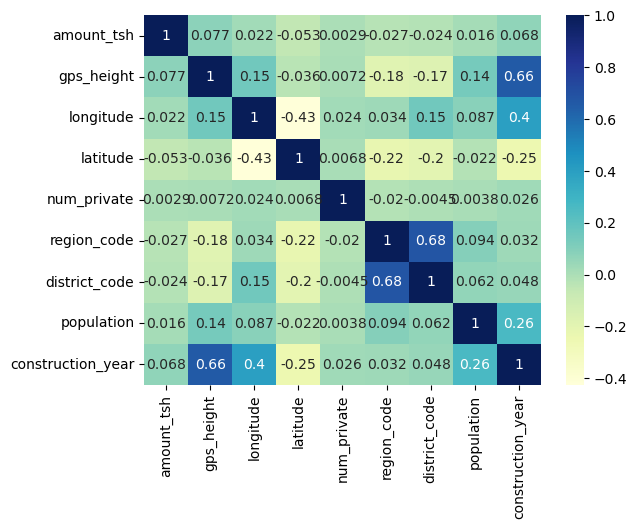

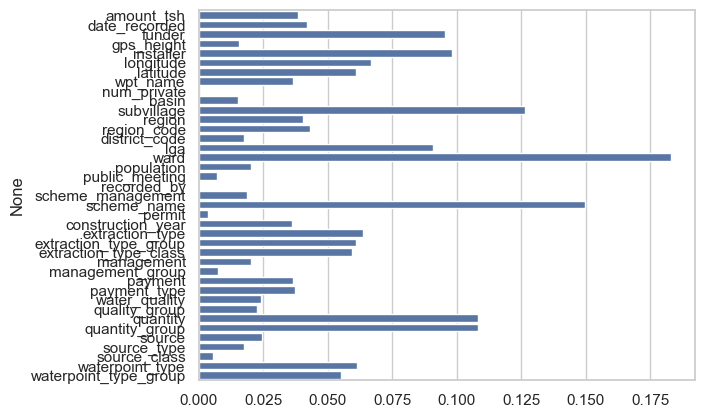

In [12]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# plotting correlation heatmap 
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True) 
plt.show() 


# ploting a bar chart for Mutual Information Scores
mis = np.array([])

# calculate MI scores for each feature, adding the result to a list
for x_label in df:
    feature = df[[x_label]].apply(LabelEncoder().fit_transform)
    mi_score = mutual_info_classif(feature, original['status_group'])[0]
    mis = np.append(mis, mi_score)

sns.set_theme(style="whitegrid")
sns.barplot(x=mis, y=df.columns, orient='h')
plt.show()


# Factor Analysis of Mixed Data
Factor Analysis of Mixed Data (FAMD) is a statistical method used for analyzing datasets containing both qualitative (categorical) and quantitative (numeric) variables.

For each identified group we conducted FAMD and display the results, which show the varince stored in the new component features, and how much each feature in the exsisting dataframe contributes to the new components. We can use this to assess whihch featrures are the most important

Again, when these values are high it can be down to a large set of categories within the features, which may cause overfitting and so care should be taken when selecting features. 

In [ ]:
!pip install prince

In [120]:
import prince

labels = ['funder', 'installer', 'scheme_management', 'scheme_name', 'management', 'management_group']

dataset = df[labels].copy()
dataset = dataset.iloc[:5000] 

mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)

mca = mca.fit(dataset)

mca.plot(
    dataset,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

chart = mca.plot(dataset, x_component=0, y_component=1)
chart.display()

print(mca.eigenvalues_summary)

x = mca.column_contributions_.style.format('{:.0%}').data

x.reset_index(inplace=True)
# Add the 'name' label to the first column
x.insert(0, 'name', x['index'])
# Drop the original index column if needed
x.drop(columns=['index'], inplace=True)
# Split the names on the last underscore and take the first two parts
x['name'] = x['name'].str.rsplit('_', n=1).str[0]
# Group by the modified names and aggregate by summing up the percentages for each column
# Select all numeric columns for aggregation
aggregation_functions = {col: 'sum' for col in x.columns if col != 'name' and pd.api.types.is_numeric_dtype(x[col])}
x = x.groupby('name').agg(aggregation_functions).reset_index()
# Round the percentages
x[x.columns.difference(['name'])] = x[x.columns.difference(['name'])].round(2)

x

alt.LayerChart(...)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.731         0.18%                      0.18%
1              0.682         0.16%                      0.34%
2              0.602         0.14%                      0.48%


name     0     1     2
0             funder  0.18  0.22  0.26
1        funder_Kkkt  0.00  0.00  0.00
2          installer  0.20  0.21  0.26
3    installer_KKKT   0.00  0.00  0.00
4         management  0.17  0.16  0.14
5   management_group  0.15  0.16  0.08
6  scheme_management  0.15  0.12  0.14
7        scheme_name  0.14  0.13  0.12

In [115]:
labels=['gps_height', 'longitude', 'latitude', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward']
dataset = df[labels].copy()
dataset = dataset.iloc[:5000] 

famd = prince.FAMD(
    n_components=5,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)

famd = famd.fit(dataset)

chart = famd.plot(dataset, x_component=0, y_component=1)
chart.display()

print(famd.eigenvalues_summary)

famd.column_contributions_.style.format('{:.0%}')

alt.LayerChart(...)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0             26.748         0.10%                      0.10%
1             23.881         0.09%                      0.18%
2             23.069         0.08%                      0.26%
3             22.378         0.08%                      0.34%
4             21.502         0.08%                      0.42%


In [112]:
labels = ['extraction_type', 'extraction_type_group', 'extraction_type_class', 'waterpoint_type', 'waterpoint_type_group']
dataset = df[labels].copy()
dataset = dataset.iloc[:5000] 

mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)

mca = mca.fit(dataset)

mca.plot(
    dataset,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

chart = mca.plot(dataset, x_component=0, y_component=1)
chart.display()

print(mca.eigenvalues_summary)

x = mca.column_contributions_.style.format('{:.0%}').data

x.reset_index(inplace=True)
# Add the 'name' label to the first column
x.insert(0, 'name', x['index'])
# Drop the original index column if needed
x.drop(columns=['index'], inplace=True)

# Split the names on the last underscore and take the first two parts
x['name'] = x['name'].str.rsplit('_', n=1).str[0]

# Group by the modified names and aggregate by summing up the percentages for each column
# Select all numeric columns for aggregation
aggregation_functions = {col: 'sum' for col in x.columns if col != 'name' and pd.api.types.is_numeric_dtype(x[col])}
x = x.groupby('name').agg(aggregation_functions).reset_index()

# Round the percentages
x[x.columns.difference(['name'])] = x[x.columns.difference(['name'])].round(2)

x


alt.LayerChart(...)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.984        11.44%                     11.44%
1              0.853         9.91%                     21.35%
2              0.632         7.35%                     28.70%
3              0.600         6.98%                     35.67%
4              0.600         6.98%                     42.65%


name    0     1     2     3     4
0        extraction_type  0.2  0.21  0.31  0.33  0.33
1  extraction_type_class  0.2  0.21  0.31  0.33  0.33
2  extraction_type_group  0.2  0.21  0.31  0.33  0.33
3        waterpoint_type  0.2  0.18  0.07  0.00  0.00
4  waterpoint_type_group  0.2  0.18  0.01  0.00  0.00

In [76]:
labels = ['source', 'source_type', 'source_class', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'amount_tsh']
dataset = df[labels].copy()
dataset = dataset.iloc[:5000] 

famd = prince.FAMD(
    n_components=5,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)

famd = famd.fit(dataset)

chart = famd.plot(dataset, x_component=0, y_component=1)
chart.display()

print(famd.eigenvalues_summary)

famd.column_contributions_.style.format('{:.0%}')

alt.LayerChart(...)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0             12.029         9.47%                      9.47%
1             10.857         8.55%                     18.02%
2             10.493         8.26%                     26.28%
3              9.320         7.34%                     33.62%
4              8.181         6.44%                     40.06%


# funder & installer

Initially there are far to many different funders and installers for the data to be useful. However, some are much more prolific than others. When we combine the less prevelant ones into an 'other' category, we can see that some funders and installers have very different ratios of status types. Finding a way to make this data more general to reduce overfitting may be useful

funder

                         funder
count                    55765
unique                    1897
top     Government Of Tanzania
freq                      9084

 funder                
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Malola                       1
Maliasili                    1
Males                        1
Makusa                       1
Zingibali Secondary          1
Length: 1897, dtype: int64 

funder_processed

        funder_processed
count             55765
unique                9
top               Other
freq              35052

 funder_processed      
Other                     35052
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef               

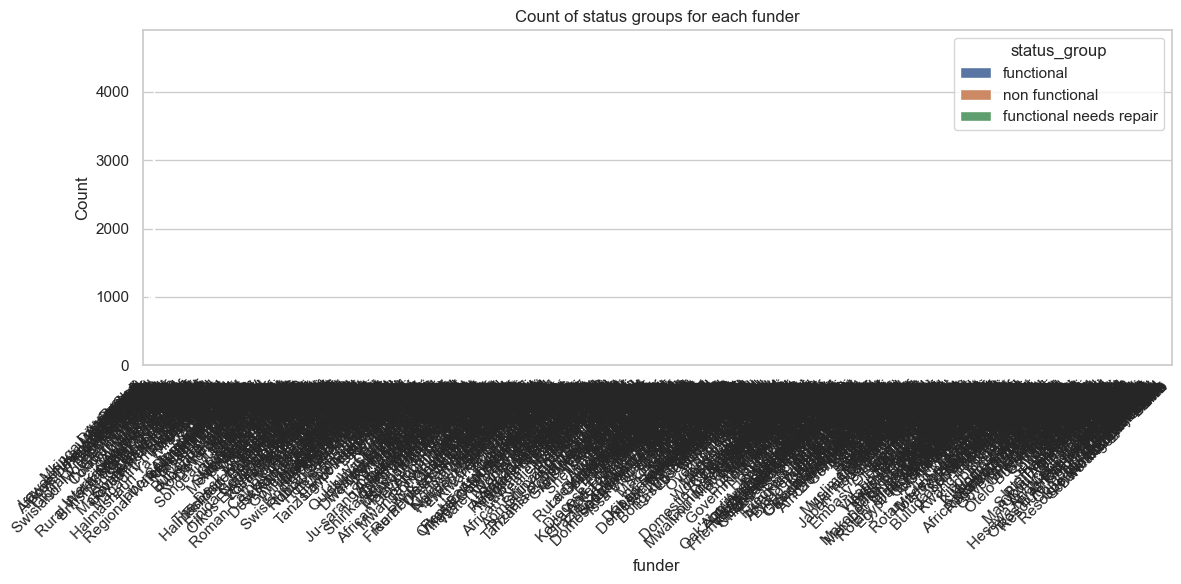

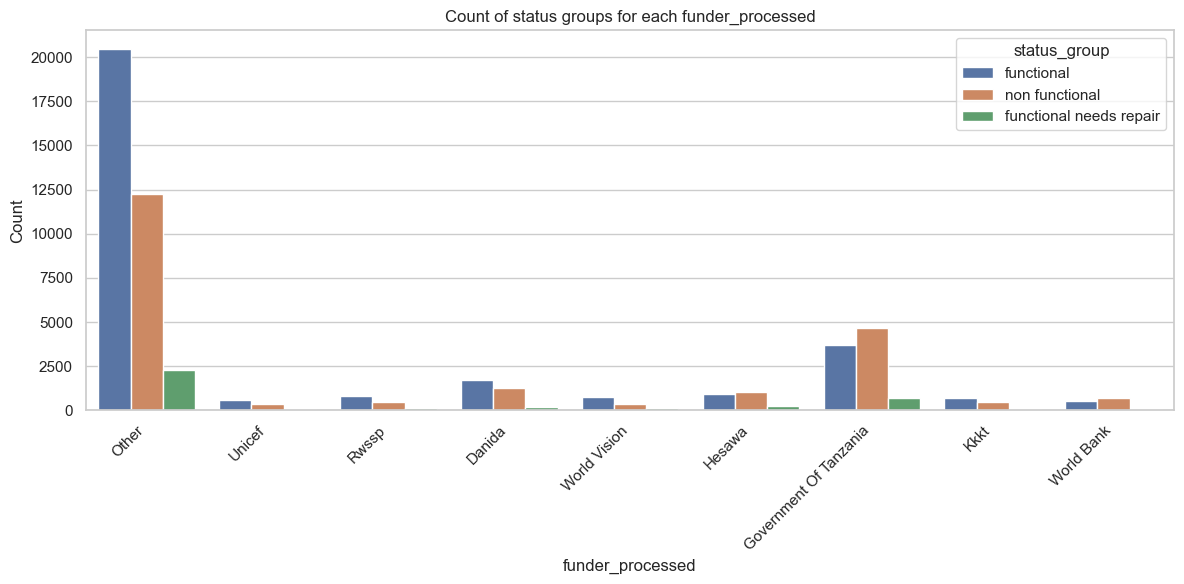

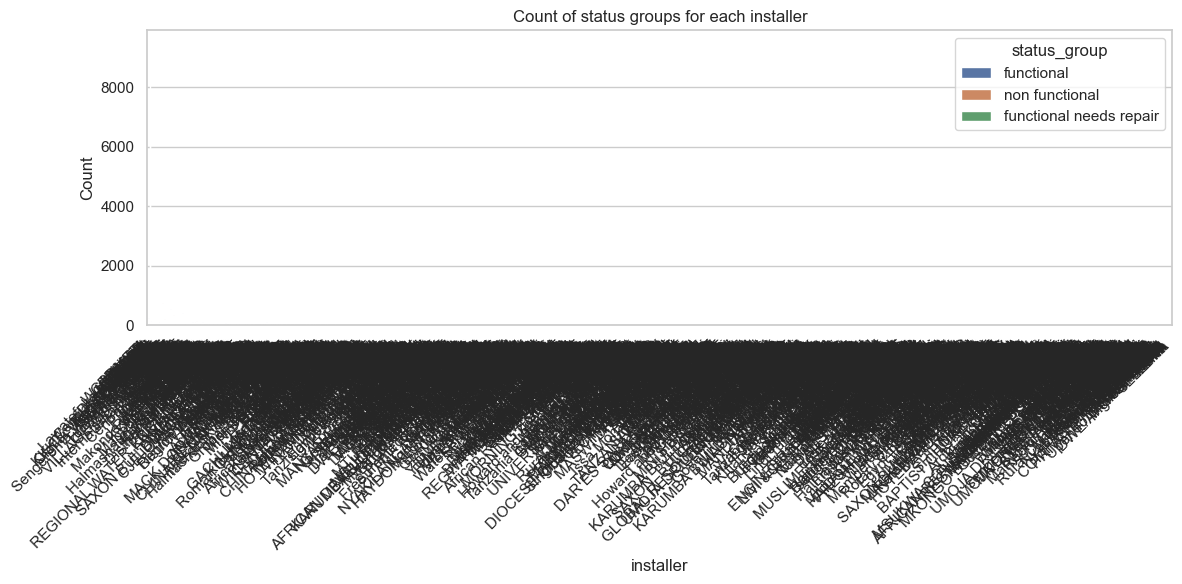

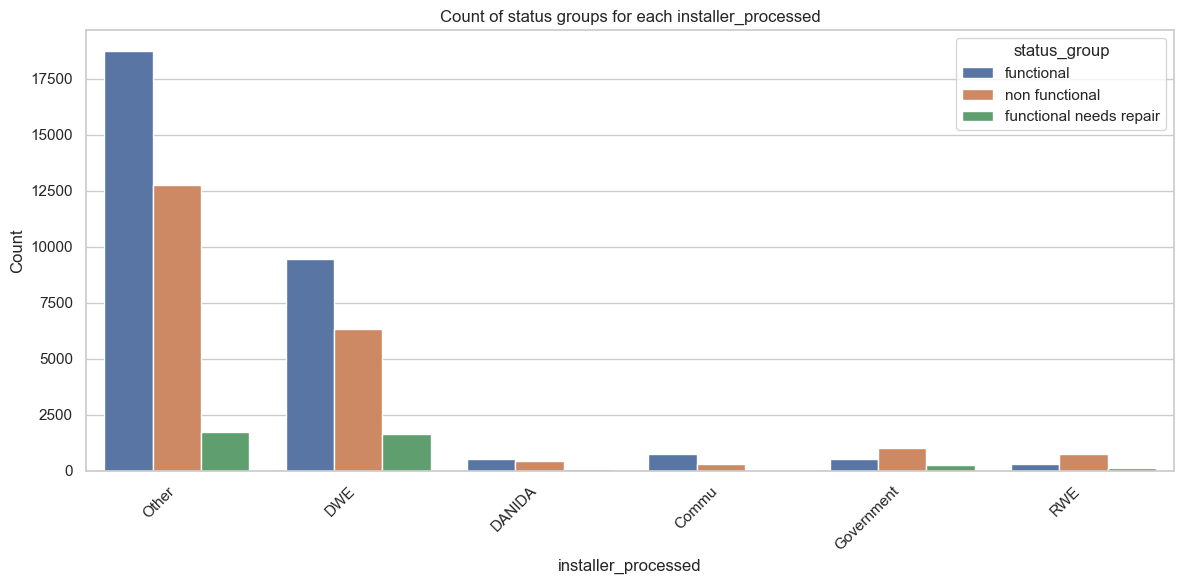

In [40]:
#The feature being examined
x_labels = ['funder', 'funder_processed', 'installer', 'installer_processed']

df['funder_processed'] = df['funder'].apply(lambda x: 'Other' if (pd.notna(x) and df['funder'].value_counts()[x] < 1000) else x)
df['installer_processed'] = df['installer'].apply(lambda x: 'Other' if (pd.notna(x) and df['installer'].value_counts()[x] < 1000) else x)


#show some basic statistics about the feature
for x_label in x_labels: 
    print(x_label)
    print("\n", df[[x_label]].describe())
    print("\n", df[[x_label]].value_counts(), "\n")
    
for x_label in x_labels:
    # displaying the distribution of the selected feature
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.countplot(data=df, x= x_label, hue=original['status_group'])

    # Rotating x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Adding labels and title
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for each ' + x_label)

    # Show plot
    plt.tight_layout()
    plt.show()
    


# scheme_name & managment

both of these features have a many missing values which need to be replaced. scheme managment has a low mutual information score with status type, sugessting it is not a great predictor. scheme name has a very high score, but this is likely due to the extremly large amount of categories. This will lead to overfitting. Some of the scheme names are used multiple times though, and this could proide useful information. when we only show scheme names that are used the most, with the others being combine into one category, we can see a variation in ratios for the status types, this could be helpful for predicting, although this may correlate to the ward / district of the pump as many of the schemes are named after the local communities.

A way to cluster the names could be used.


 scheme_name    2696
dtype: int64

 scheme_management    12
dtype: int64

 name_processed    1
dtype: int64


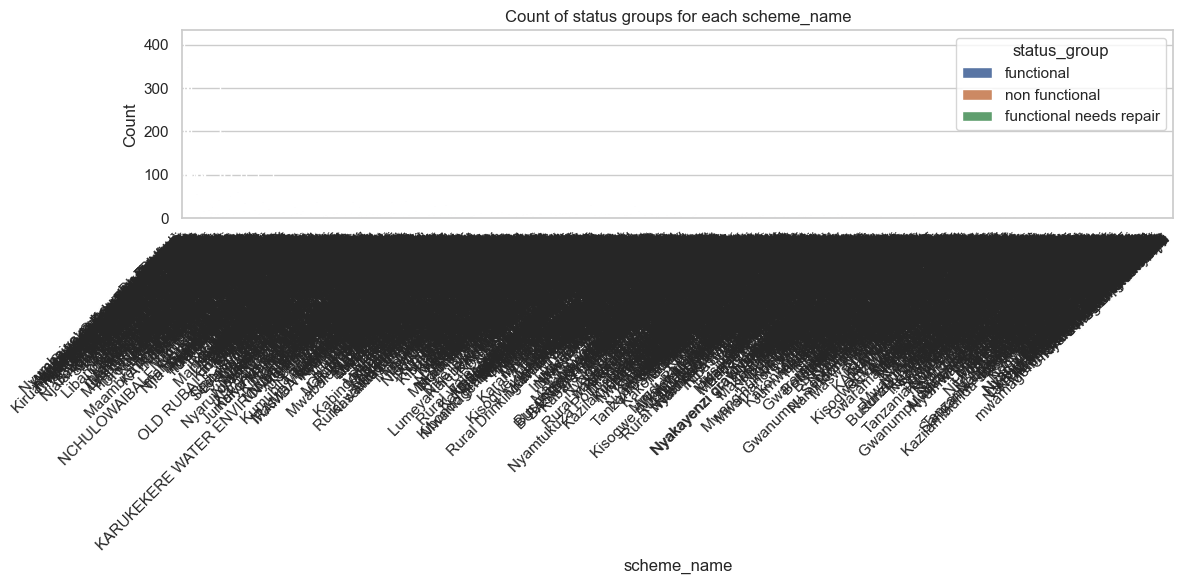

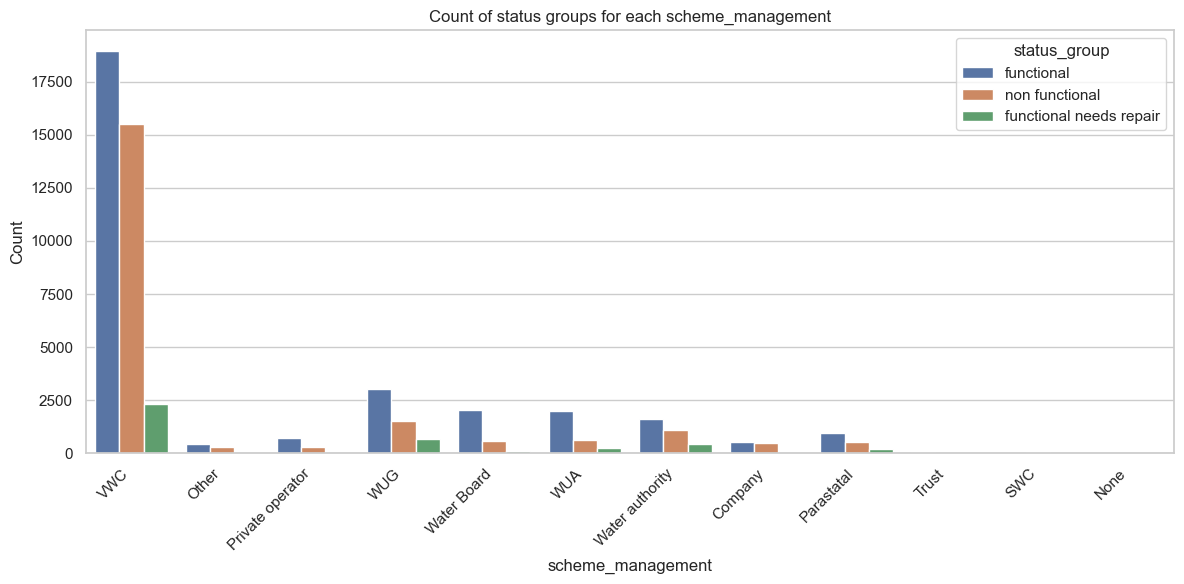

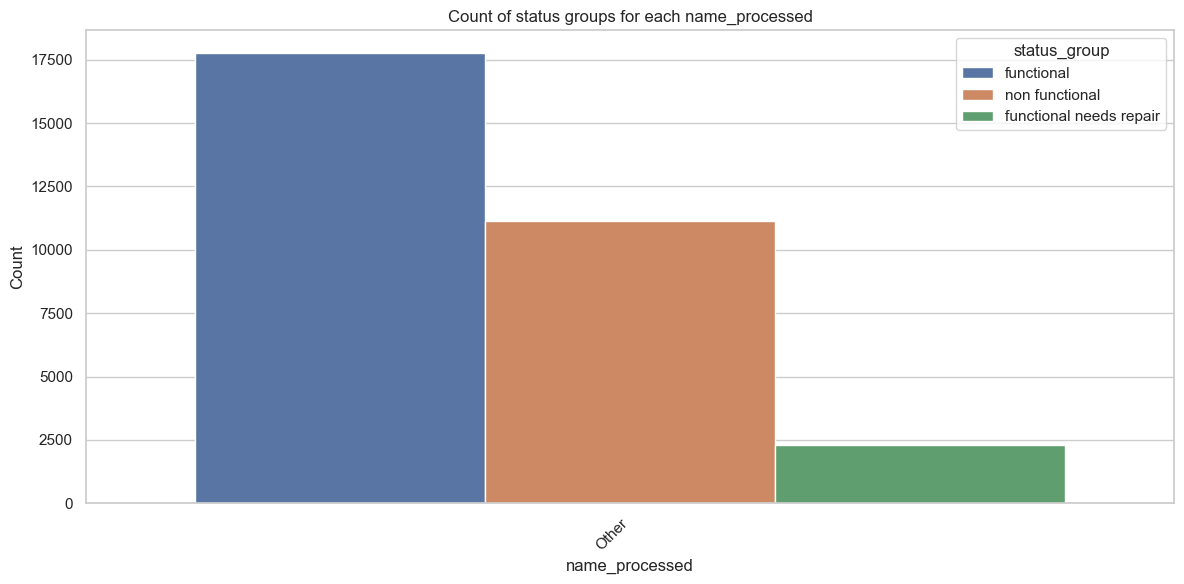

In [27]:
#the features being examined
x_labels = ['scheme_name', 'scheme_management', 'name_processed']

# grouping all name values that are used less than 2000 times into one.
df['name_processed'] = df['scheme_name'].apply(lambda x: 'Other' if (pd.notna(x) and df['scheme_name'].value_counts()[x] < 2000) else x)


#show some basic statistics about the feature
for x_label in x_labels: 
    print("\n", df[[x_label]].nunique())
    
    
for x_label in x_labels:
    # displaying the distribution of the selected feature
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.countplot(data=df, x= x_label, hue=original['status_group'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for each ' + x_label)
    plt.tight_layout()
    plt.show()

# managment & managment group

Again these features seem to be similar, with the managment feature having near identical groups but with a few additional categories, as such the group feature can be removed. Both of these features have a lower mutual information score whith the status type when compare to the other features, and so may not be the best predictors.


 management_group    5
dtype: int64

 management    12
dtype: int64


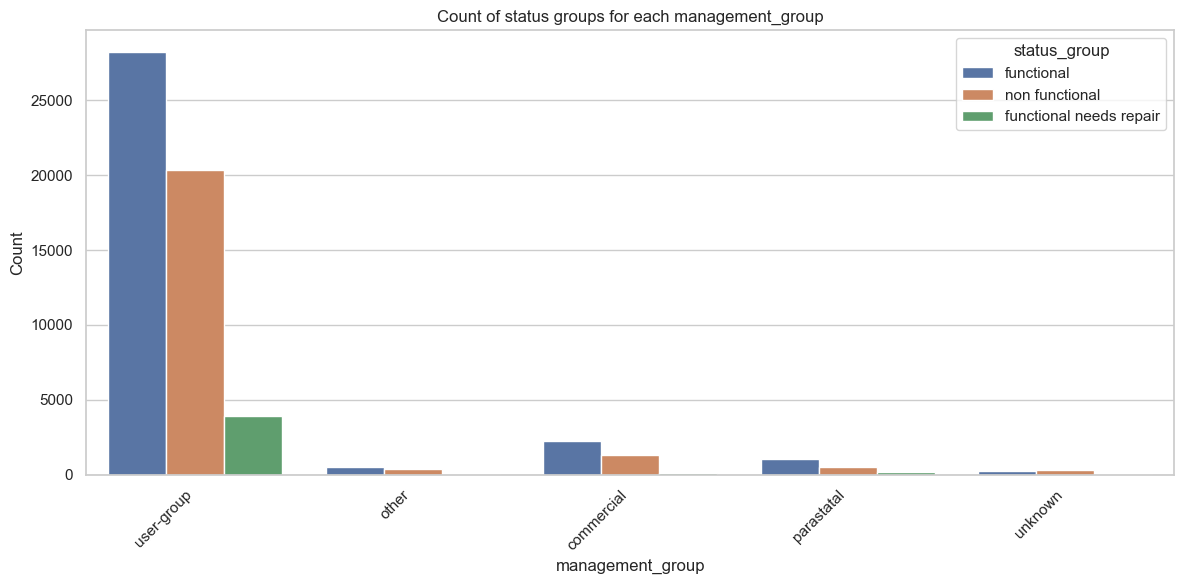

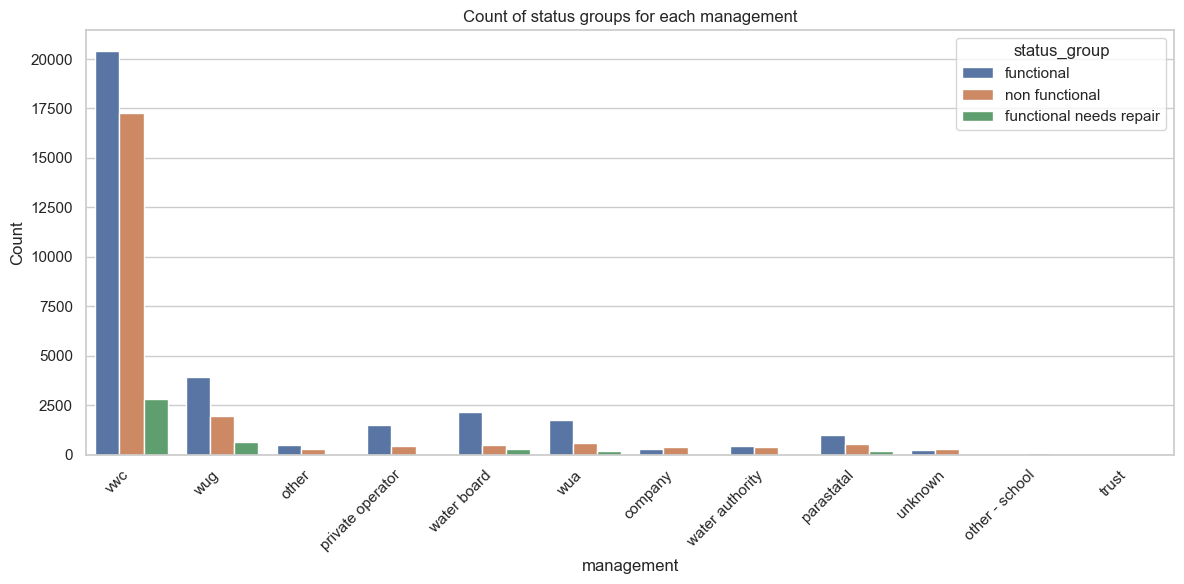

In [24]:
#The feature being examined
x_labels = ['management_group', 'management']

#show some basic statistics about the feature
for x_label in x_labels: 
    print("\n", df[[x_label]].nunique())
    
    
for x_label in x_labels:
    # displaying the distribution of the selected feature
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.countplot(data=df, x= x_label, hue=original['status_group'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for each ' + x_label)
    plt.tight_layout()
    plt.show()

# location data

there are many features indicating the location of the pumps, some of these are far to specific (subvillage & ward) and might cause overfitting, wheras features like basin are quite general and don't offer much insight.

region and lga have more reasonable variable counts, and have there data distributed faitly evenly across all categories. region & district code are also reasonable features.

Experimentation should be done to determine the best feature, with minimal overfitting. 


 district_code    20
dtype: int64

 region_code    27
dtype: int64


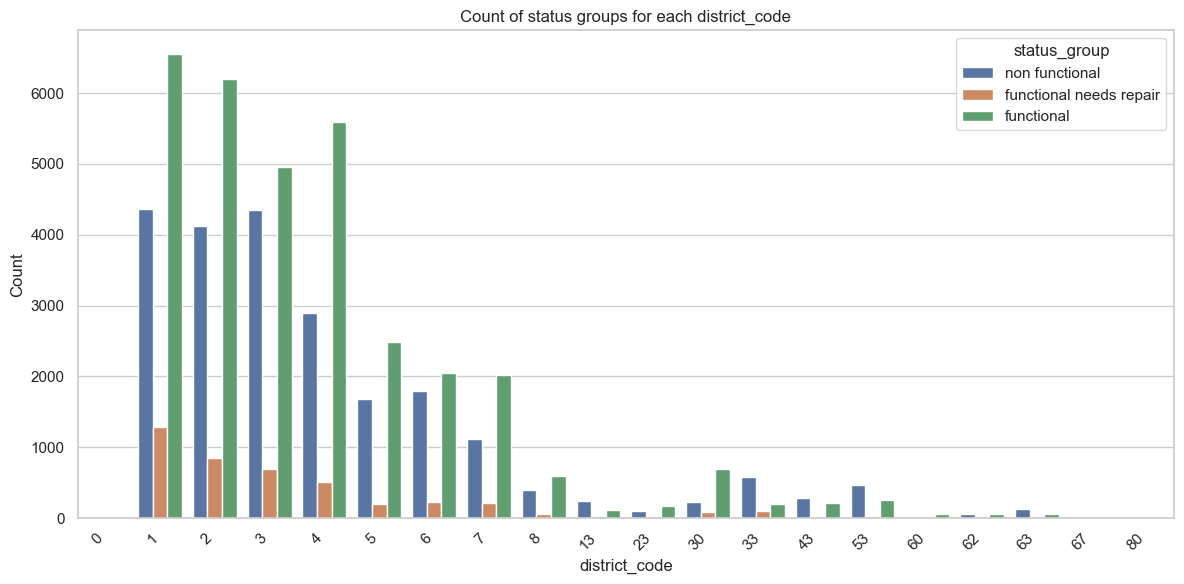

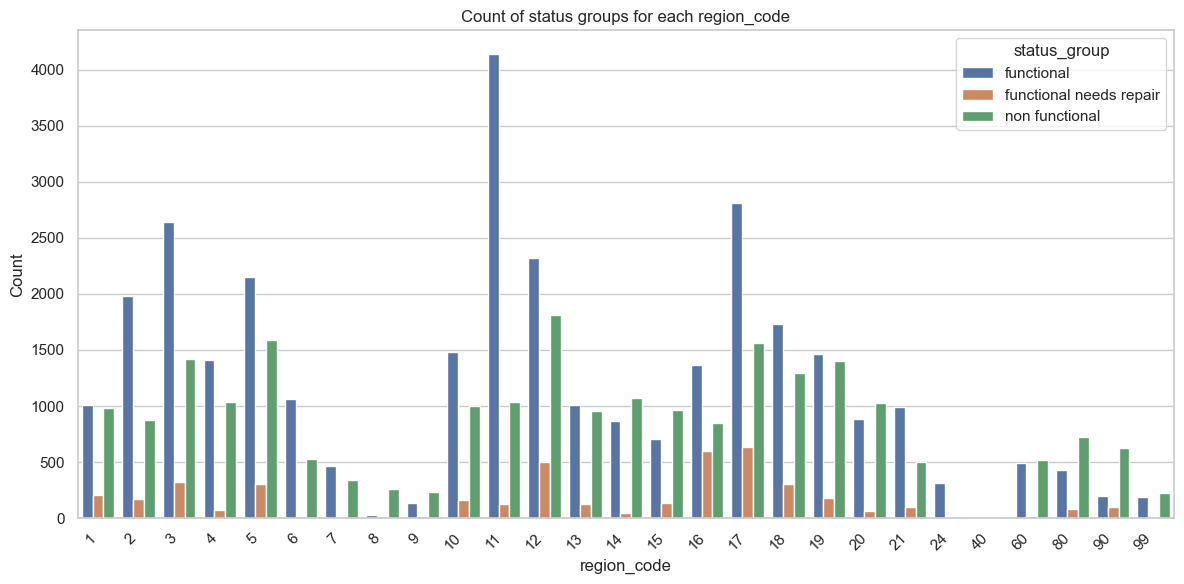

In [19]:
#the features being examined
x_labels = ['district_code', 'region_code']

#show some basic statistics about the feature
for x_label in x_labels: 
    print("\n", df[[x_label]].nunique())
    
    
for x_label in x_labels:
    # displaying the distribution of the selected feature
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.countplot(data=df, x= x_label, hue=original['status_group'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for each ' + x_label)
    plt.tight_layout()
    plt.show()


 ward    2092
dtype: int64

 lga    125
dtype: int64

 region    21
dtype: int64

 subvillage    19287
dtype: int64

 basin    9
dtype: int64


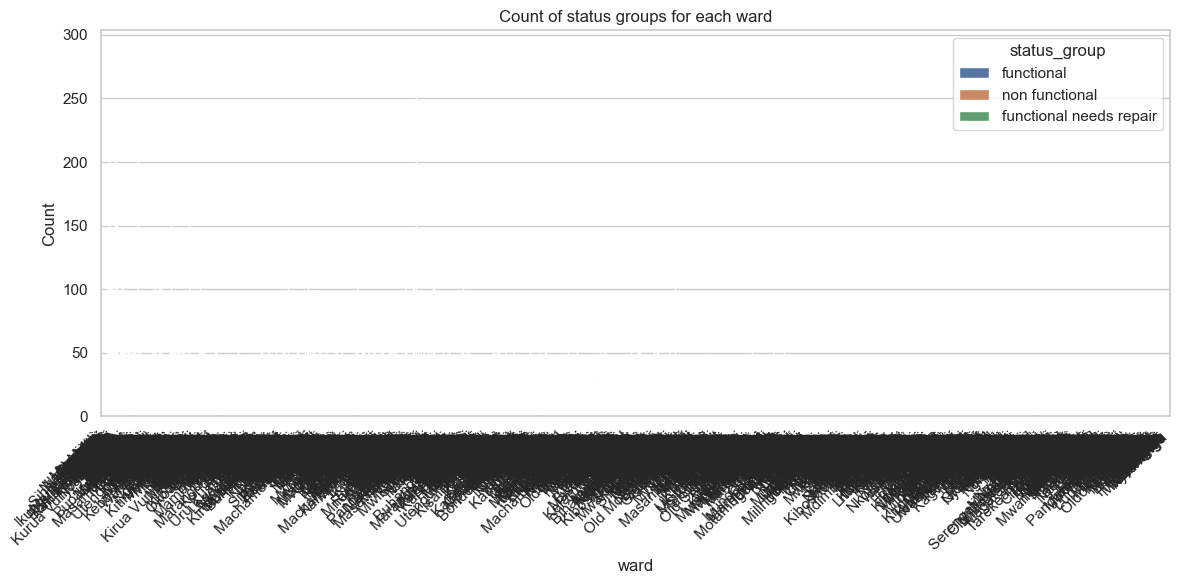

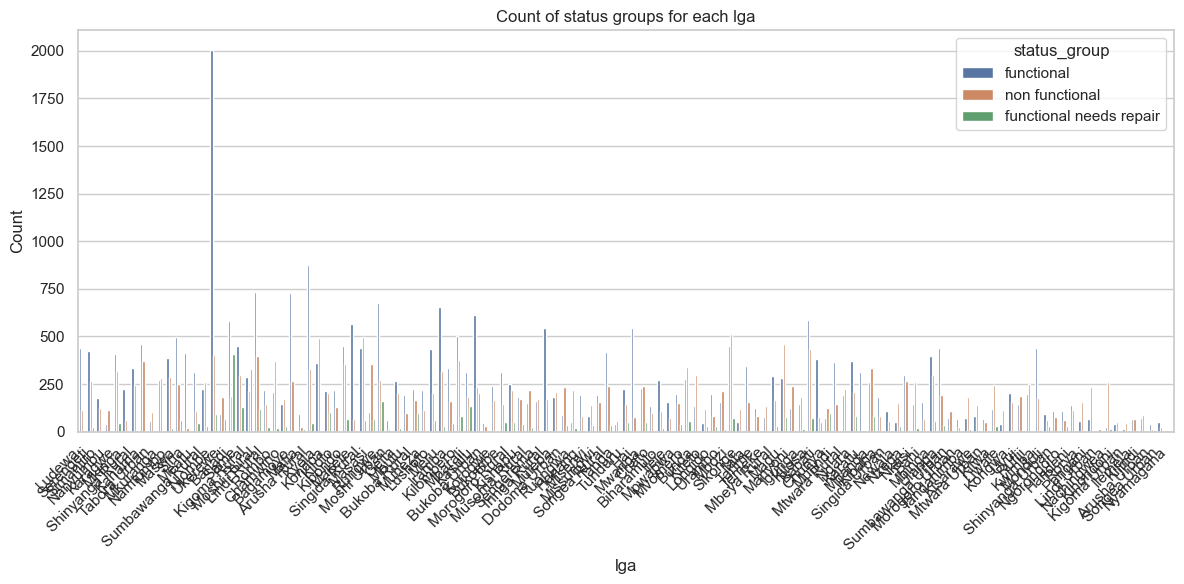

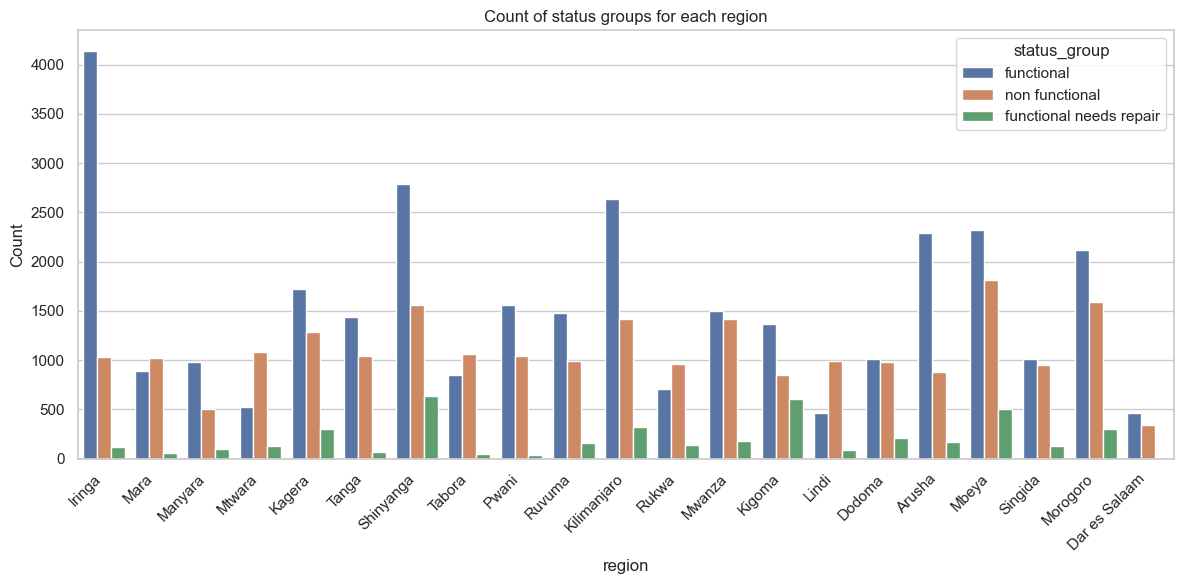

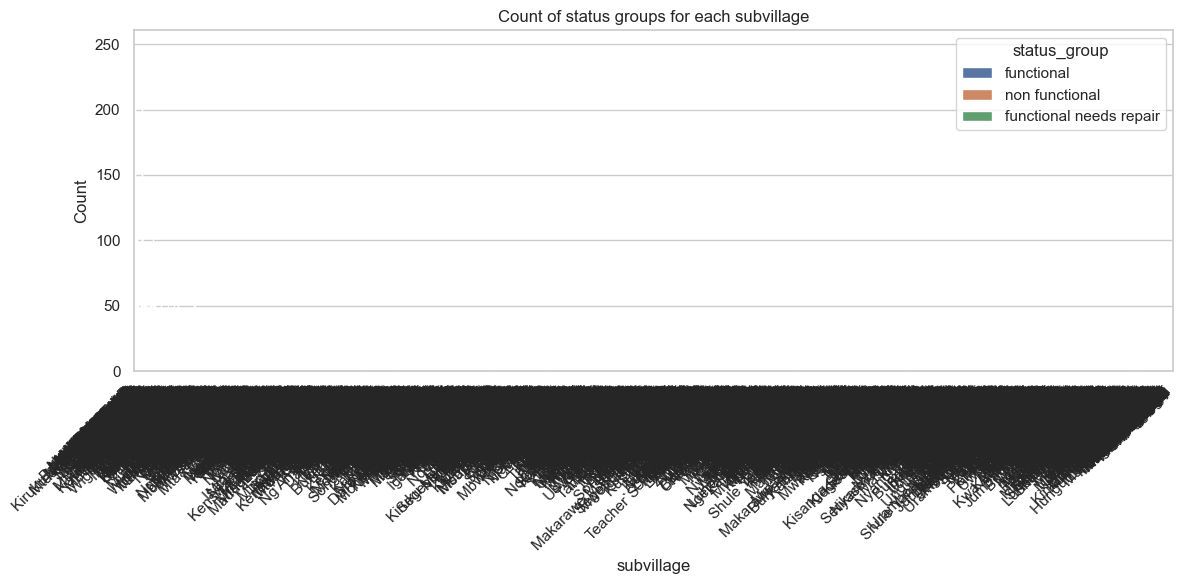

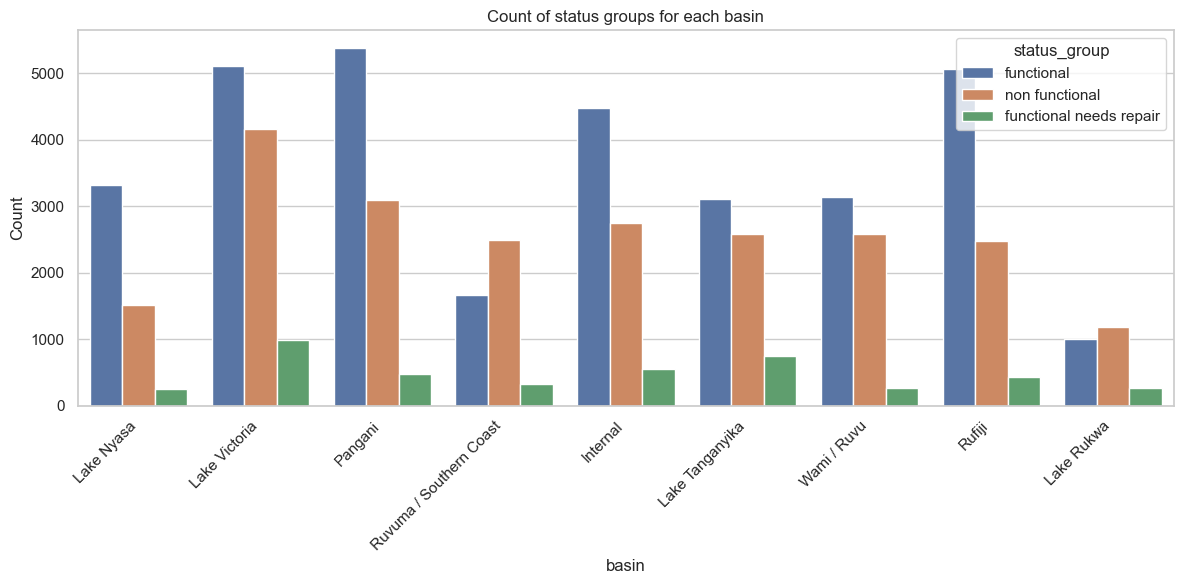

In [21]:
#The feature being examined
x_labels = ['ward', 'lga', 'region', 'subvillage', 'basin']
#show some basic statistics about the feature
for x_label in x_labels: 
    print("\n", df[[x_label]].nunique())
    
for x_label in x_labels:
    # displaying the distribution of the selected feature
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.countplot(data=df, x= x_label, hue=original['status_group'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for each ' + x_label)
    plt.tight_layout()
    plt.show()


# gps data
we can claearly see that '0' has been used as a NaN value for many of these data points.

         gps_height
count  59400.000000
mean     668.297239
std      693.116350
min      -90.000000
25%        0.000000
50%      369.000000
75%     1319.250000
max     2770.000000
          longitude
count  59400.000000
mean      34.077427
std        6.567432
min        0.000000
25%       33.090347
50%       34.908743
75%       37.178387
max       40.345193
           latitude
count  5.940000e+04
mean  -5.706033e+00
std    2.946019e+00
min   -1.164944e+01
25%   -8.540621e+00
50%   -5.021597e+00
75%   -3.326156e+00
max   -2.000000e-08


<Figure size 1200x600 with 0 Axes>

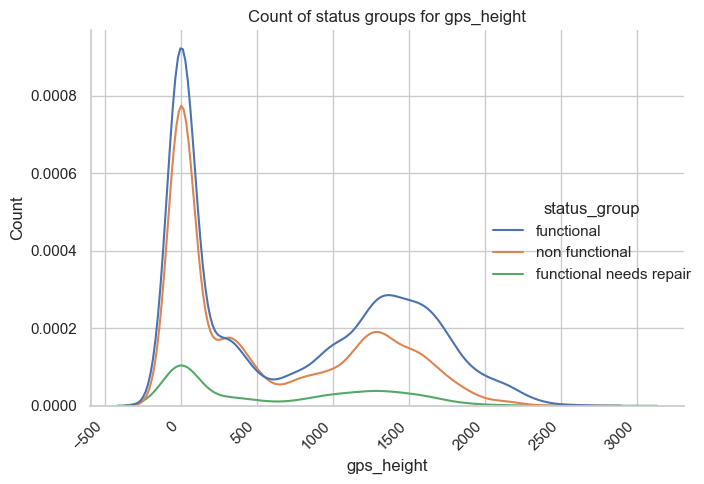

<Figure size 1200x600 with 0 Axes>

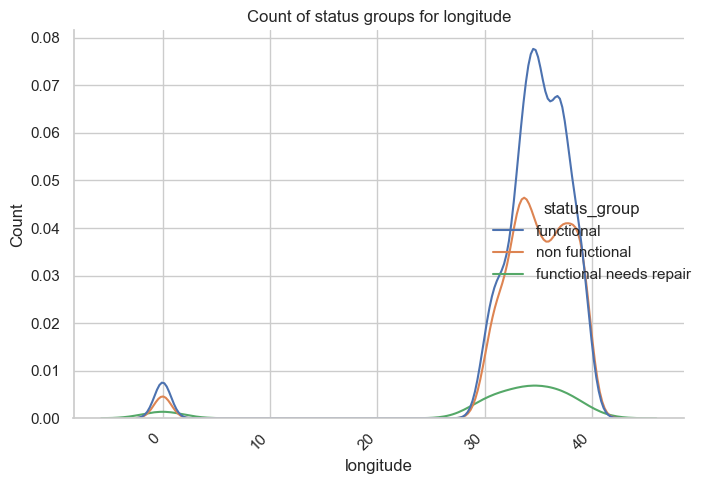

<Figure size 1200x600 with 0 Axes>

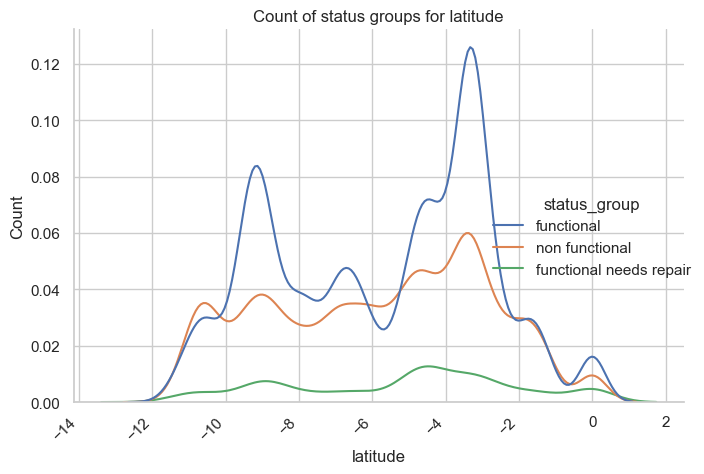

In [22]:
#The feature being examined
x_labels = ['gps_height', 'longitude', 'latitude',]

#show some basic statistics about the feature
for x_label in x_labels: 
    print(df[[x_label]].describe())

#display the distribution of data for the feature, divided by status type
for x_label in x_labels: 
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.displot(data=df, x= x_label, hue=original['status_group'], kind='kde')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for ' + x_label)
    plt.tight_layout()
    plt.show()


# population

this feature has quite a low mutual information score with status type, meaning it is unlikley to be particularly helpful. There is a large proprtion of values wqual to 0 suggesting this may be a null value, but it could just indicate that the watersource is located away from a community. In the lower end of the value range the ratio of status types is not particularly informatve and is not impacted by the presence of 0 values. above 5000 there is some useful distribution changes, however the count of values in this range is very low and may lead to overfitting. These values could be binned.

         population
count  59400.000000
mean     179.909983
std      471.482176
min        0.000000
25%        0.000000
50%       25.000000
75%      215.000000
max    30500.000000
       population below 5000 (including 0)
count                         37896.000000
mean                            259.997810
std                             399.651693
min                               1.000000
25%                              40.000000
50%                             150.000000
75%                             320.000000
max                            4900.000000
       population below 5000 (excluding 0)
count                         59277.000000
mean                            166.217538
std                             343.071032
min                               0.000000
25%                               0.000000
50%                              25.000000
75%                             210.000000
max                            4900.000000
       population above 5000
count            

<Figure size 1200x600 with 0 Axes>

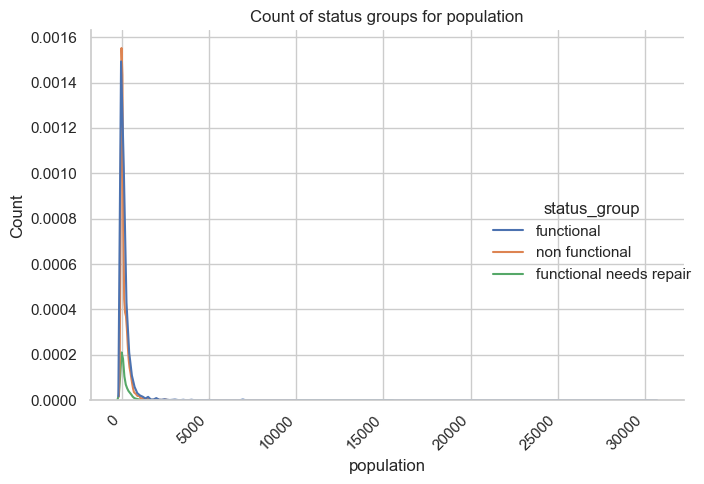

<Figure size 1200x600 with 0 Axes>

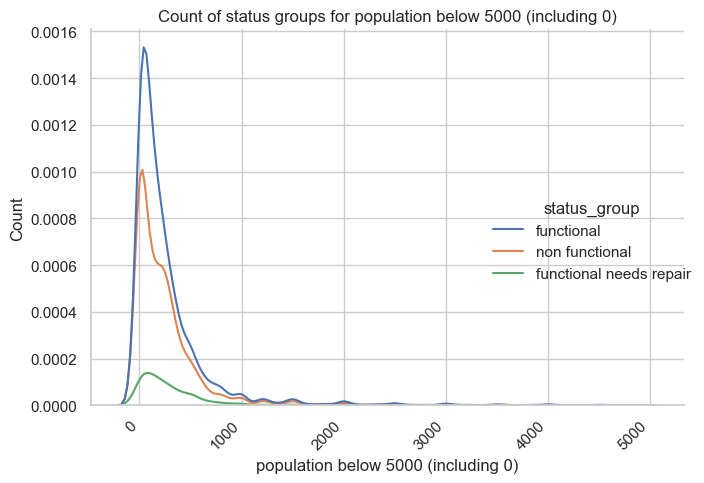

<Figure size 1200x600 with 0 Axes>

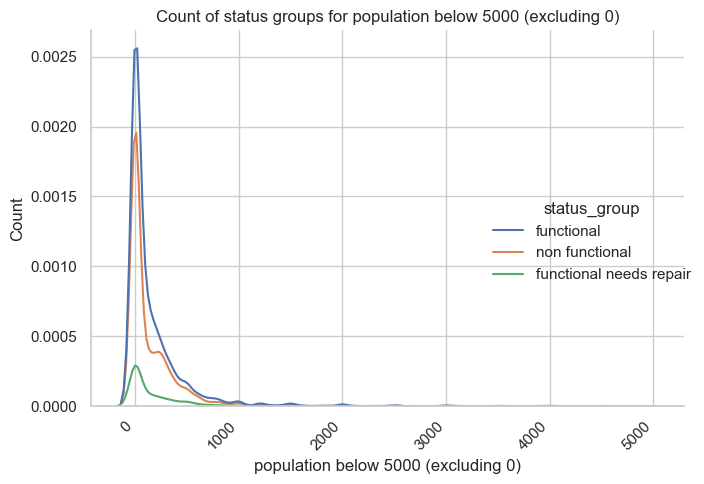

<Figure size 1200x600 with 0 Axes>

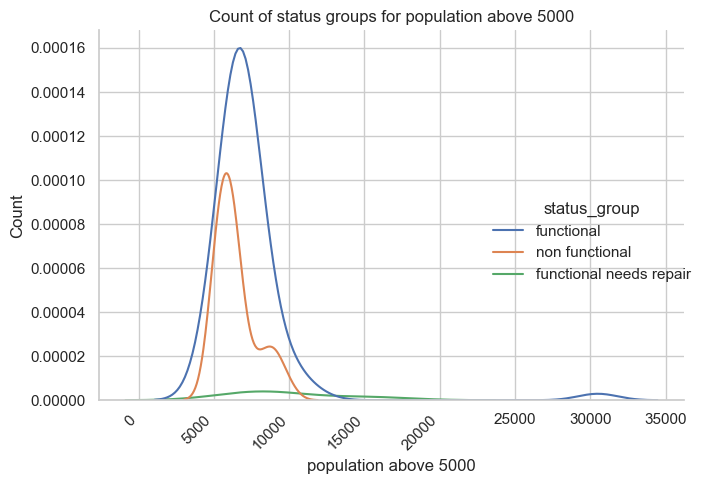

In [38]:
#The feature being examined
x_labels = ['population', 'population below 5000 (including 0)', 'population below 5000 (excluding 0)', 'population above 5000']

#display distibution of data at low values
df['population below 5000 (including 0)'] = df['population'].apply(lambda x: x if (0 < x < 5000) else None)
df['population below 5000 (excluding 0)'] = df['population'].apply(lambda x: x if (x < 5000) else None)
df['population above 5000'] = df['population'].apply(lambda x: x if (5000 < x ) else None)


#show some basic statistics about the feature
for x_label in x_labels: 
    print(df[[x_label]].describe())

#display the distribution of data for the feature, divided by status type
for x_label in x_labels: 
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.displot(data=df, x= x_label, hue=original['status_group'], kind='kde')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for ' + x_label)
    plt.tight_layout()
    plt.show()


# Construction Year

It appears that '0' has been used as a default value, and so a method to deal with this needs to be used. The data should also be converted to represent the age of the pump instead of the year that it was made.

       construction_year
count       59400.000000
mean         1300.652475
std           951.620547
min             0.000000
25%             0.000000
50%          1986.000000
75%          2004.000000
max          2013.000000


<Figure size 1200x600 with 0 Axes>

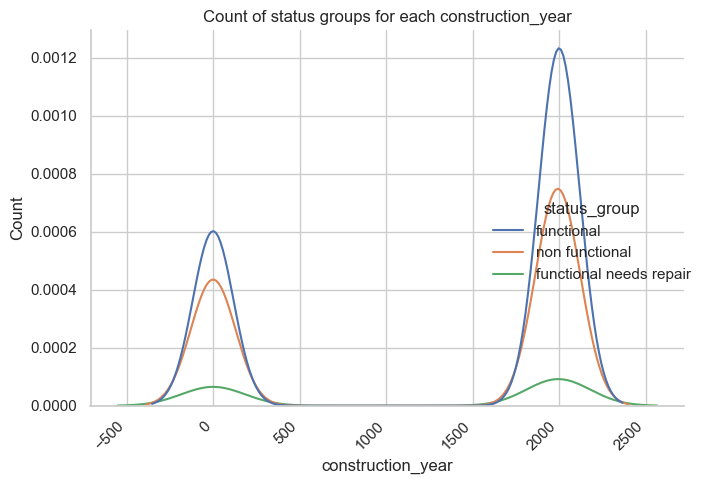

In [23]:
#The feature being examined
x_label = 'construction_year'

#show some basic statistics about the feature
print(df[[x_label]].describe())

#display the distribution of data for the feature, divided by status type
plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.displot(data=df, x= x_label, hue=original['status_group'], kind='kde')
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

# payment & payment type

These groups seem to be identical and so one can safely be removed, these features have a lower mutual information score whith the status type when compare to the other features, and so may not be the best predictors.

       payment_type
count         59400
unique            7
top       never pay
freq          25348
          payment
count       59400
unique          7
top     never pay
freq        25348


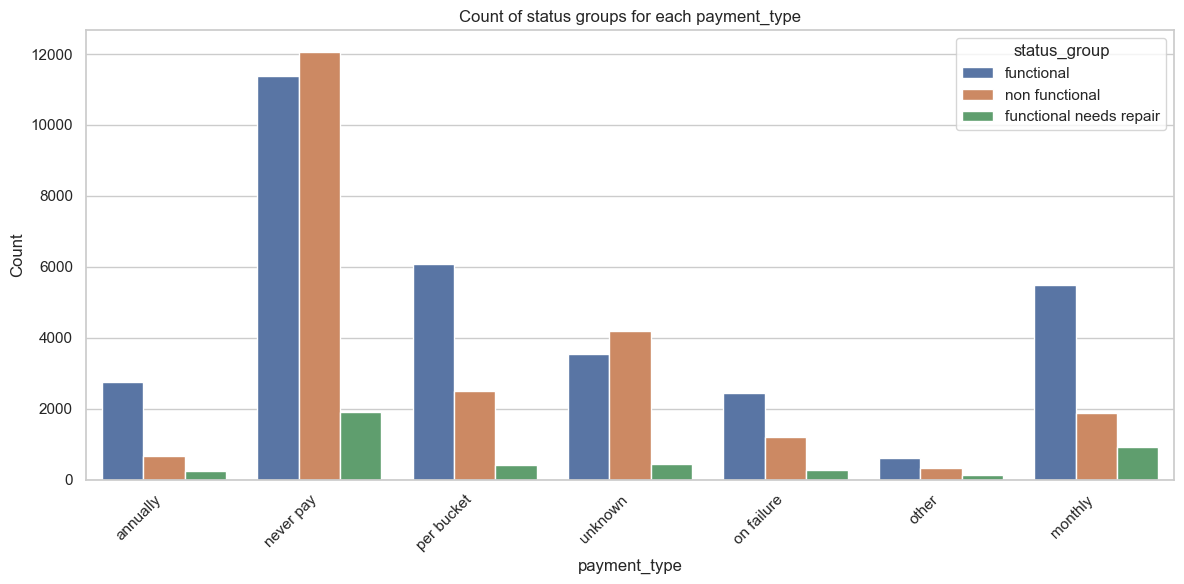

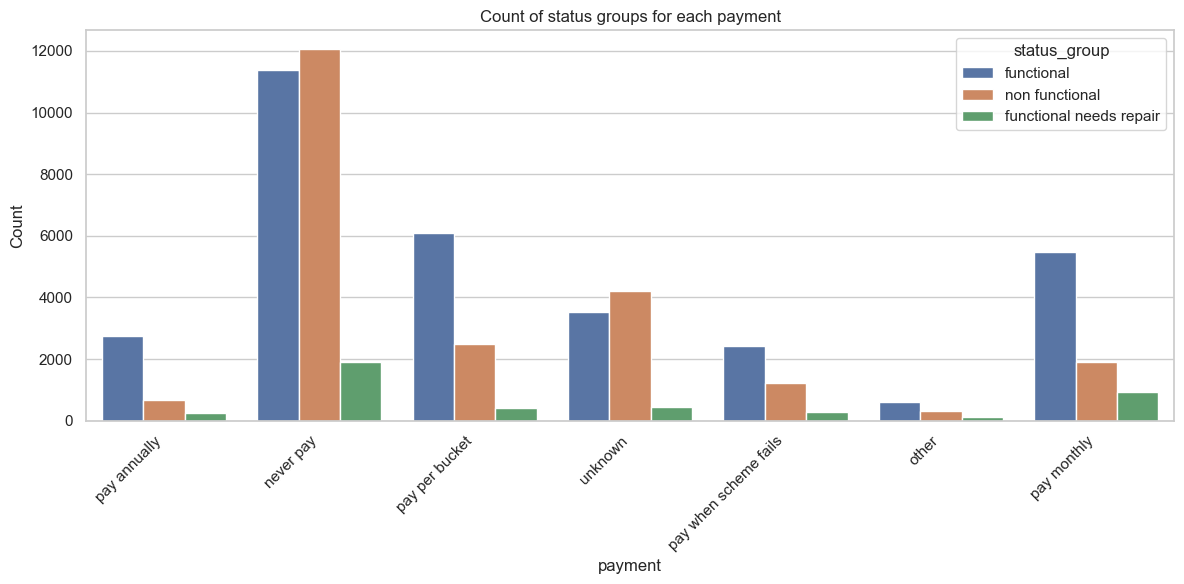

In [37]:
#The feature being examined
x_labels = ['payment_type', 'payment']

#show some basic statistics about the feature
for x_label in x_labels: 
    print(df[[x_label]].describe())

for x_label in x_labels:
    # displaying the distribution of the selected feature
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.countplot(data=df, x= x_label, hue=original['status_group'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for each ' + x_label)
    plt.tight_layout()
    plt.show()


# waterpoint type & type group

These features give us information about the type of pump, we can see that the waterpoint type provides an additional category compared to the type group feature making the later redundant. Depending on the group, the ratio of the status types ranges greatly making this seem like a useful feature.

       waterpoint_type_group
count                  59400
unique                     6
top       communal standpipe
freq                   34625
           waterpoint_type
count                59400
unique                   7
top     communal standpipe
freq                 28522


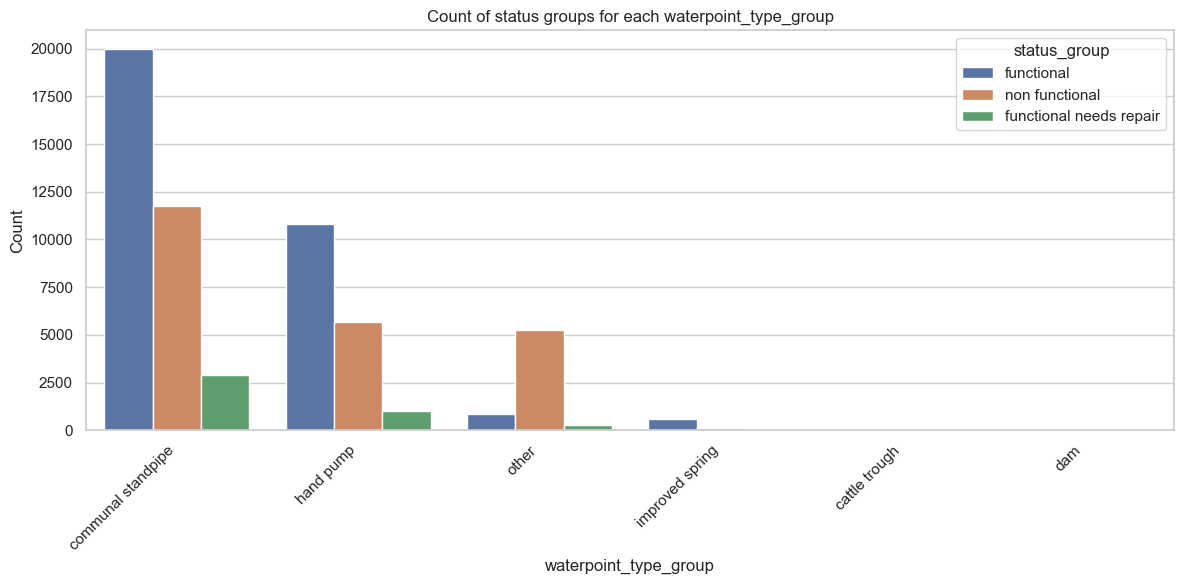

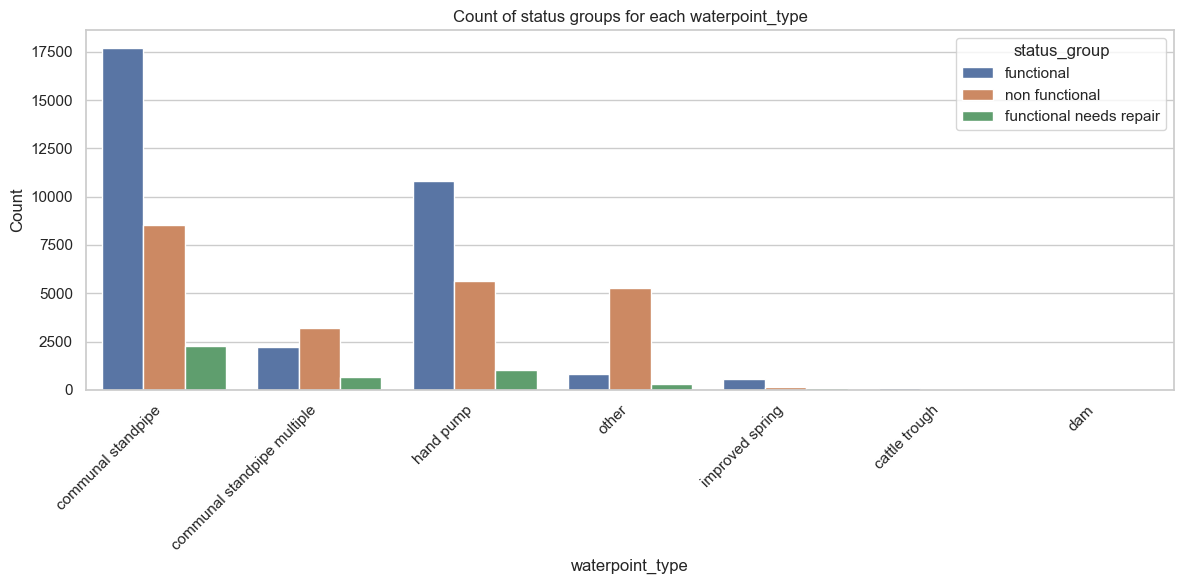

In [35]:
#The feature being examined
x_labels = ['waterpoint_type_group', 'waterpoint_type']

#show some basic statistics about the feature
for x_label in x_labels: 
    print(df[[x_label]].describe())

for x_label in x_labels:
    # displaying the distribution of the selected feature
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.countplot(data=df, x= x_label, hue=original['status_group'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for each ' + x_label)
    plt.tight_layout()
    plt.show()

# extraction type, group, and class

These features seem to be very similar, and all have a high mutual information score with status type. The extraction type feature has the most categories, however some of them only contain a few samples, this may lead to overfitting. This suggests that extraction type group may be a better feature to use.

       extraction_type
count            59400
unique              18
top            gravity
freq             26780
       extraction_type_group
count                  59400
unique                    13
top                  gravity
freq                   26780
       extraction_type_class
count                  59400
unique                     7
top                  gravity
freq                   26780


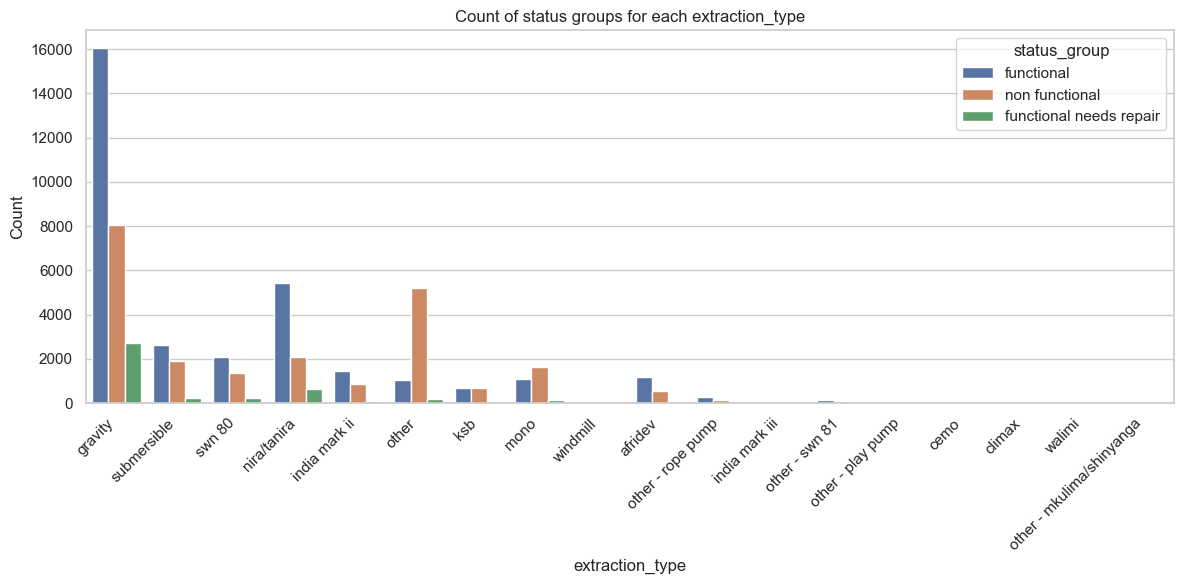

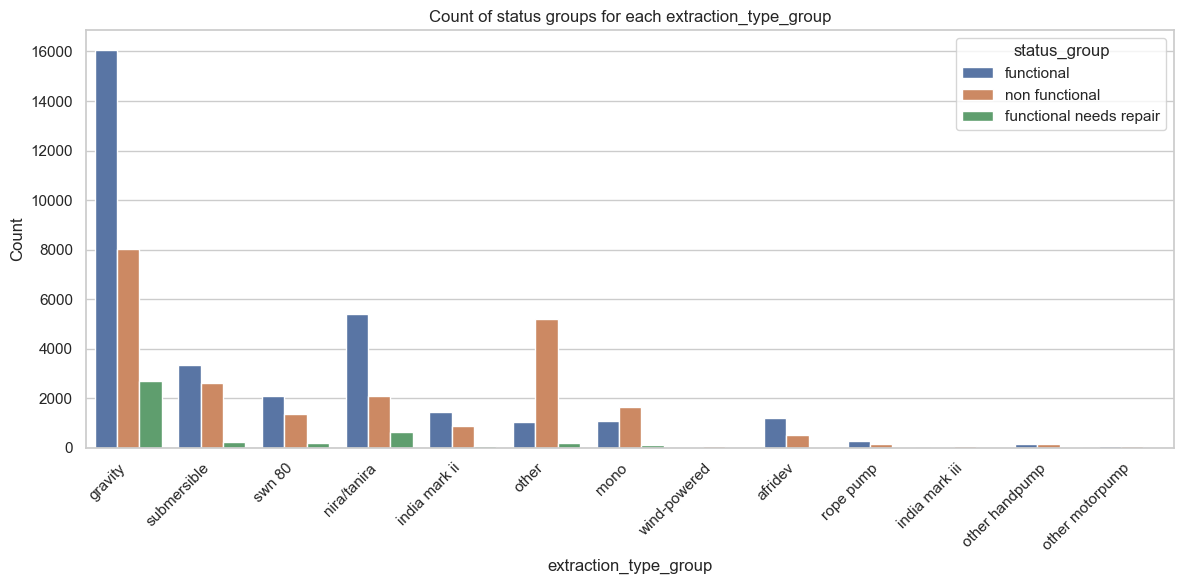

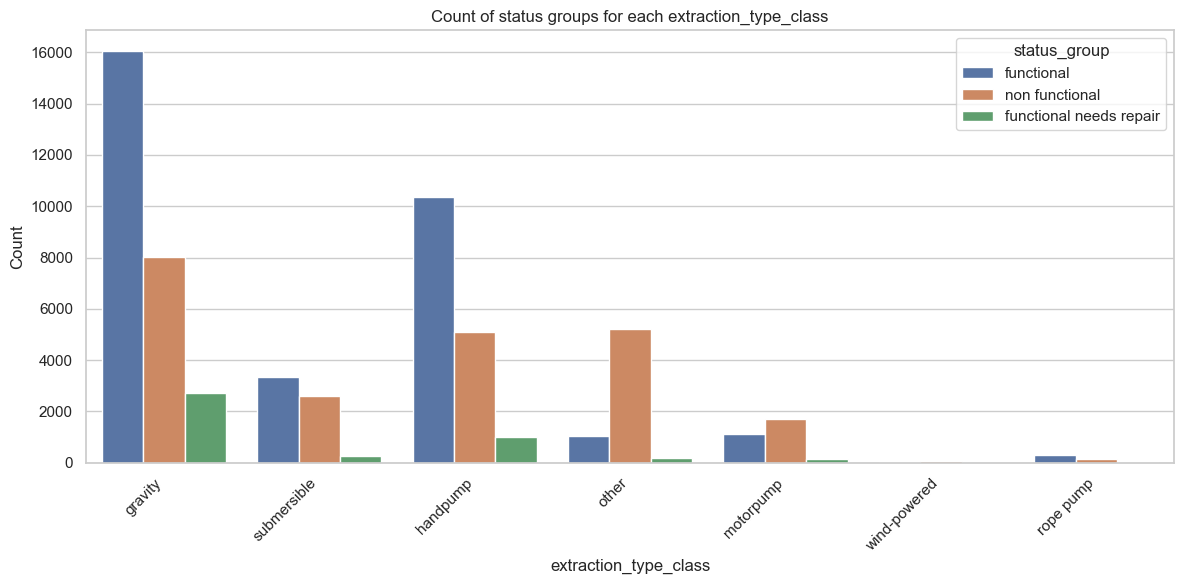

In [34]:
#The feature being examined
x_labels = ['extraction_type', 'extraction_type_group', 'extraction_type_class']

#show some basic statistics about the feature
for x_label in x_labels: 
    print(df[[x_label]].describe())

for x_label in x_labels:
    # displaying the distribution of the selected feature
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.countplot(data=df, x= x_label, hue=original['status_group'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for each ' + x_label)
    plt.tight_layout()
    plt.show()

# water quality & quality group

Again these features seem to be similar, with water quality having near identical groups but with a few additional categories, as such the quality group feature can be removed.

       quality_group
count          59400
unique             6
top             good
freq           50818
       water_quality
count          59400
unique             8
top             soft
freq           50818


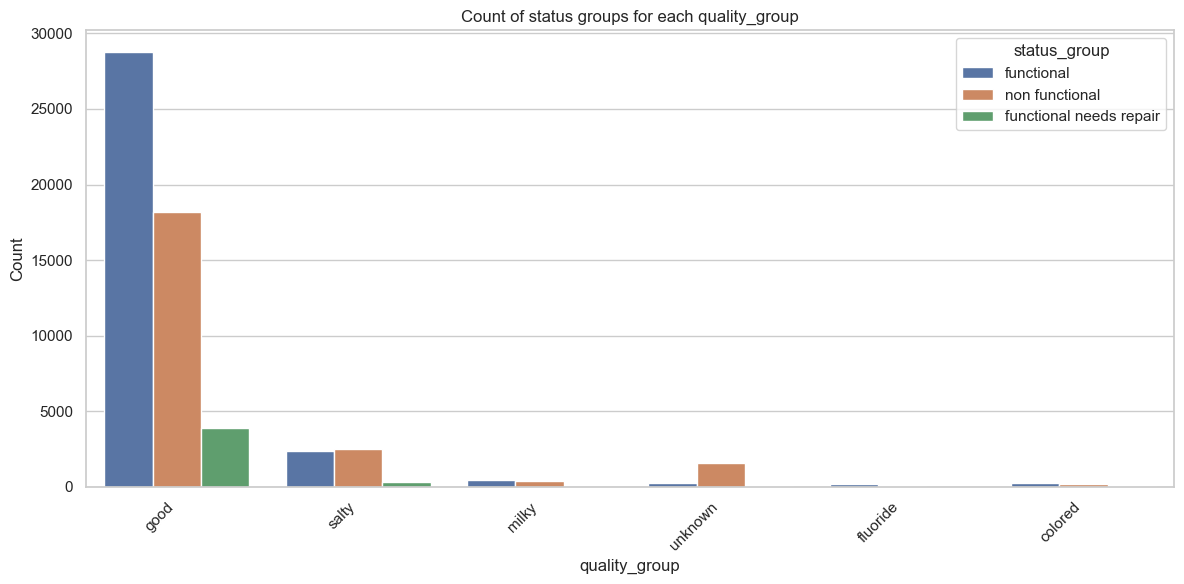

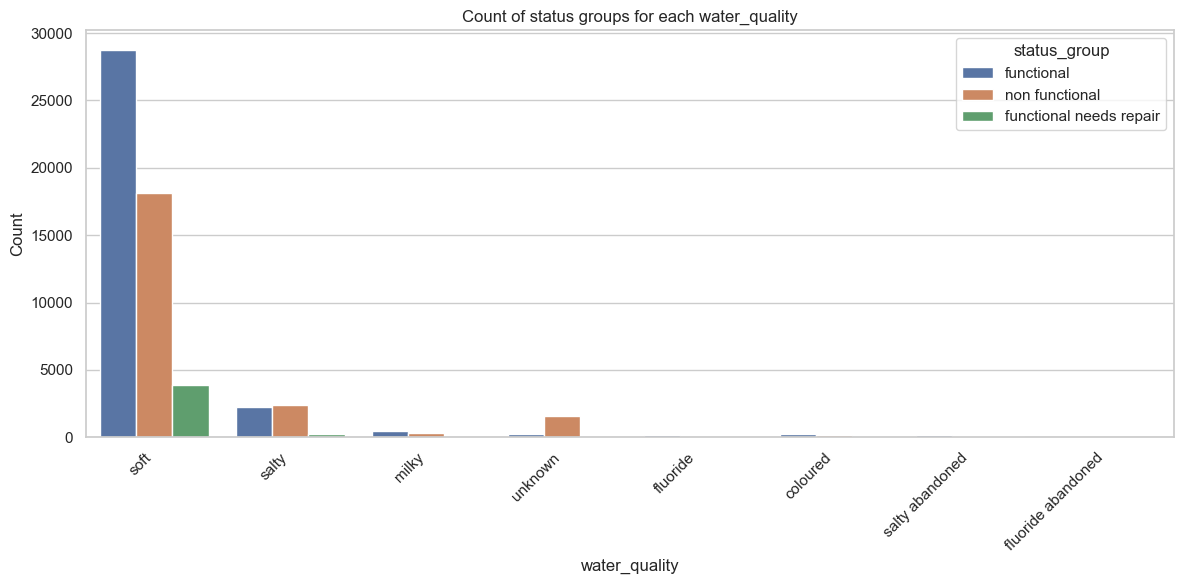

In [33]:
#The feature being examined
x_labels = ['quality_group', 'water_quality']


#show some basic statistics about the feature
for x_label in x_labels: 
    print(df[[x_label]].describe())

for x_label in x_labels:
    # displaying the distribution of the selected feature
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.countplot(data=df, x= x_label, hue=original['status_group'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for each ' + x_label)
    plt.tight_layout()
    plt.show()

# quantity and quantity group

These two features seem to be identical and so one can be safely removed, they have a high mutual information score with status group and so seem like theu could be a good predictor 

       quantity_group
count           59400
unique              5
top            enough
freq            33186
       quantity
count     59400
unique        5
top      enough
freq      33186

 quantity_group    5
dtype: int64

 quantity    5
dtype: int64


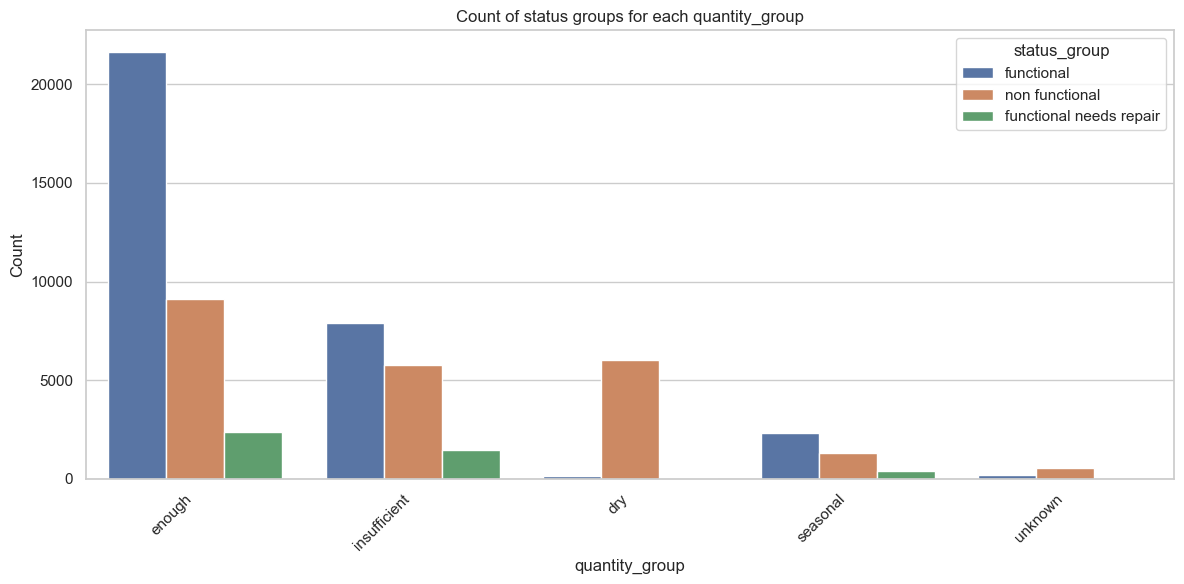

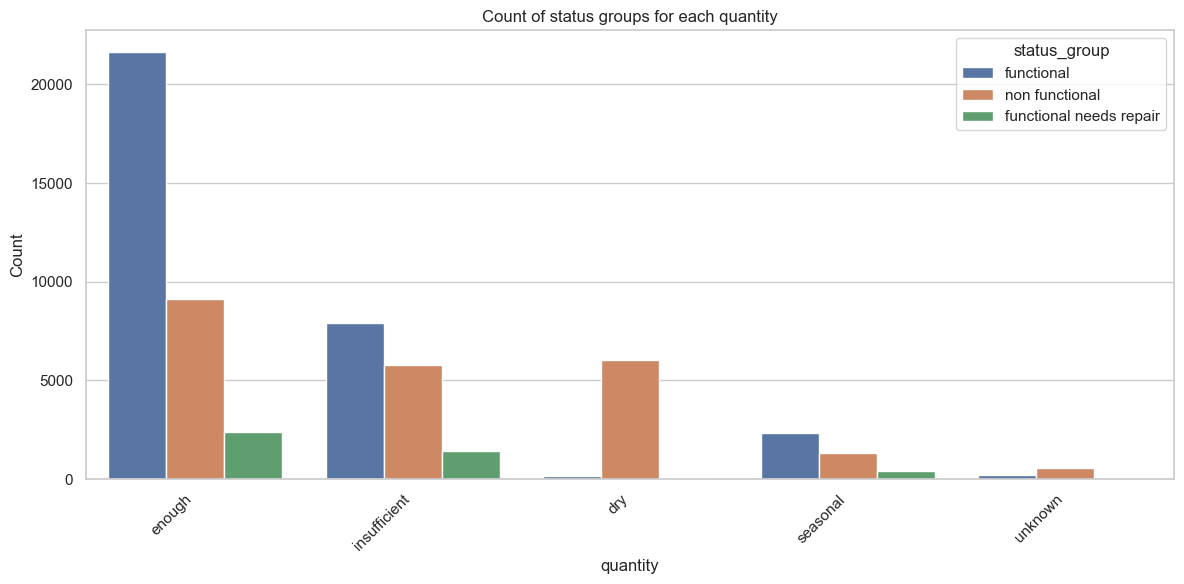

In [32]:
#The feature being examined
x_labels = ['quantity_group', 'quantity']

#show some basic statistics about the feature
for x_label in x_labels: 
    print(df[[x_label]].describe())

for x_label in x_labels:
    # displaying the distribution of the selected feature
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.countplot(data=df, x= x_label, hue=original['status_group'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for each ' + x_label)
    plt.tight_layout()
    plt.show()

# Source, source class, & type

These features are also similarly related, with the source feature haveing the most categories, and the highest mutual information score compared to the status group. source and source type seem to be very similar with slight variations in their categories, so combining these features to get the most information seem like a good idea.


 source_class    3
dtype: int64

 source_type    7
dtype: int64

 source    10
dtype: int64


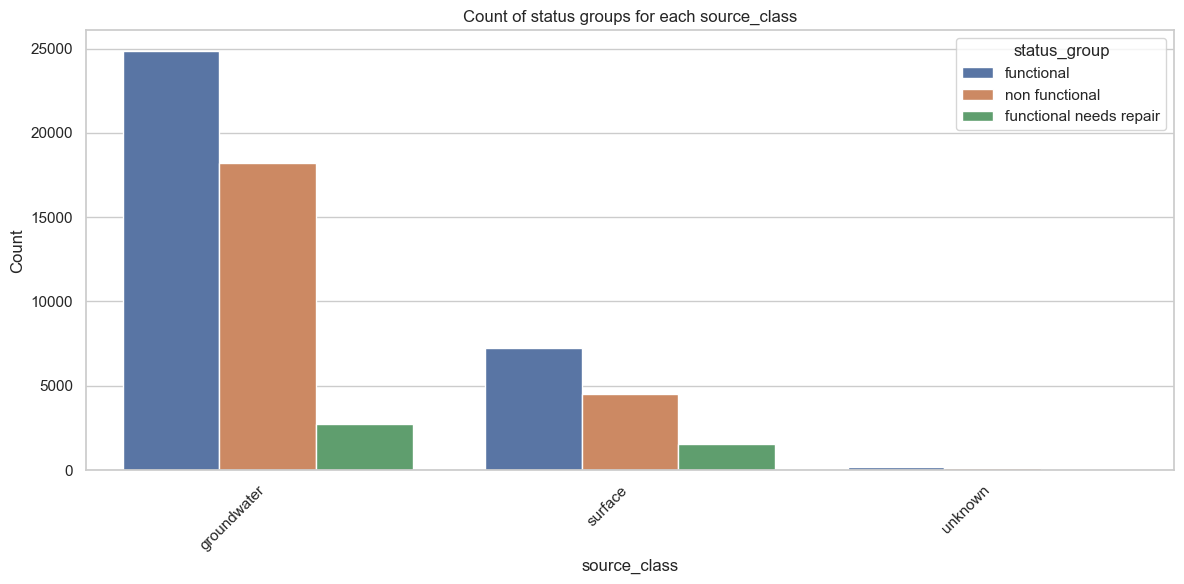

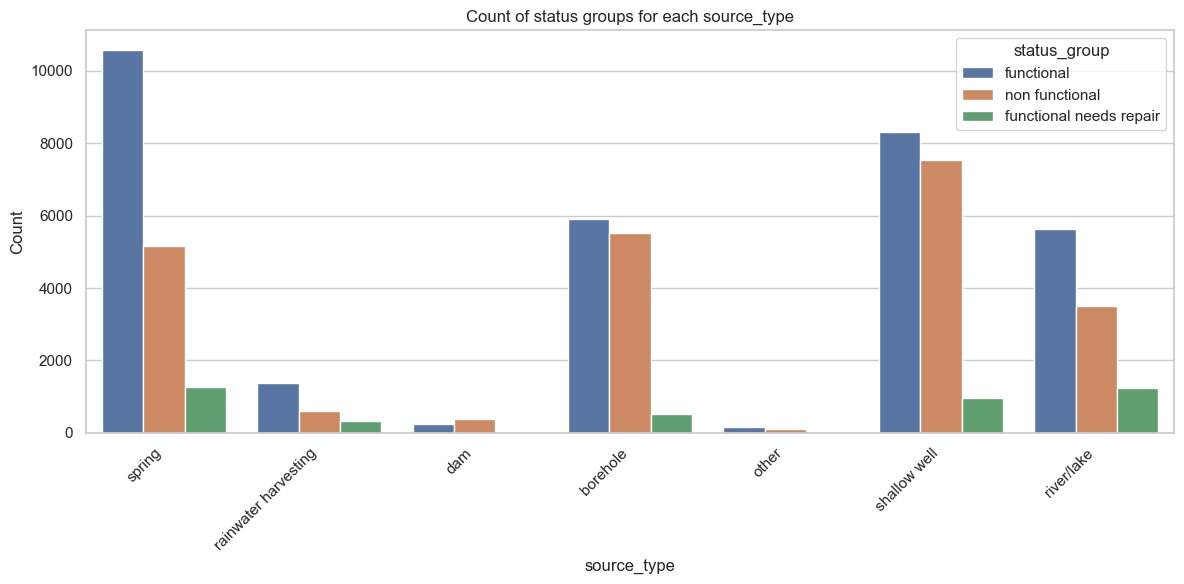

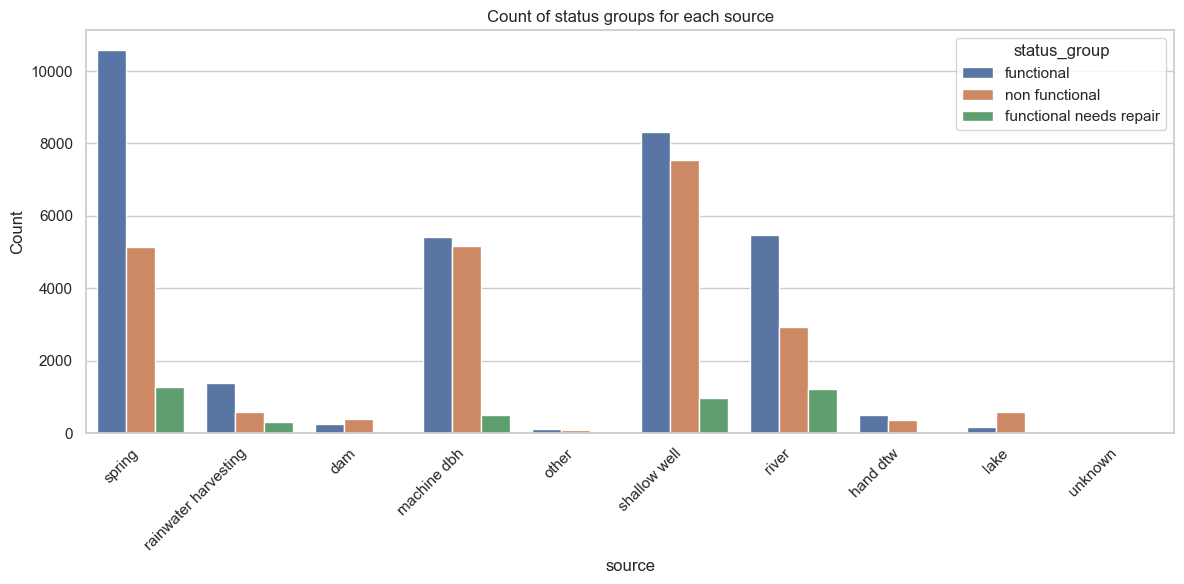

In [30]:
#The feature being examined
x_labels = ['source_class', 'source_type', 'source']

#show some basic statistics about the feature
for x_label in x_labels: 
    print(df[[x_label]].describe())

for x_label in x_labels:
    # displaying the distribution of the selected feature
    plt.figure(figsize=(12, 6))  # Adjust the size if needed
    sns.countplot(data=df, x= x_label, hue=original['status_group'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.title('Count of status groups for each ' + x_label)
    plt.tight_layout()
    plt.show()

# amount_tsh - amount water available to waterpoint

There is a large range of values here, with a majority being at 0. It is hard to tell if this is a null value, or if the pumps actually have no water availbe. We can see at the lower end of the value range, non-functional wells are more prevelant, which later skewes to being funcitional at the higher end.

This could potentially benefit from binnning the values.

          amount_tsh
count   59400.000000
mean      317.650385
std      2997.574558
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max    350000.000000


<Figure size 1200x600 with 0 Axes>

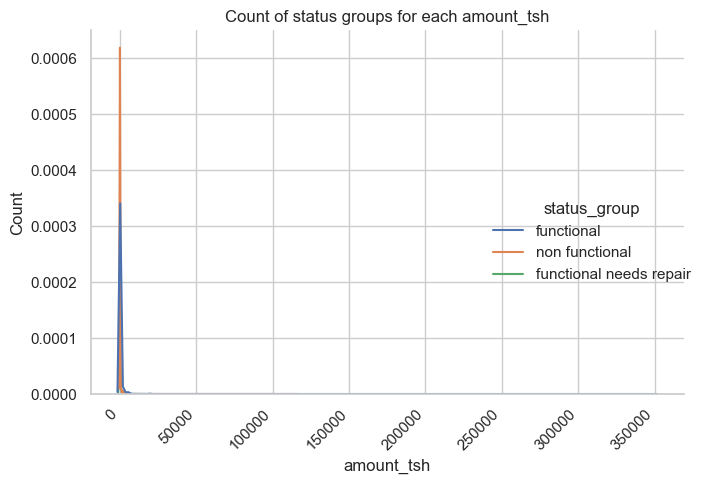

<Figure size 1200x600 with 0 Axes>

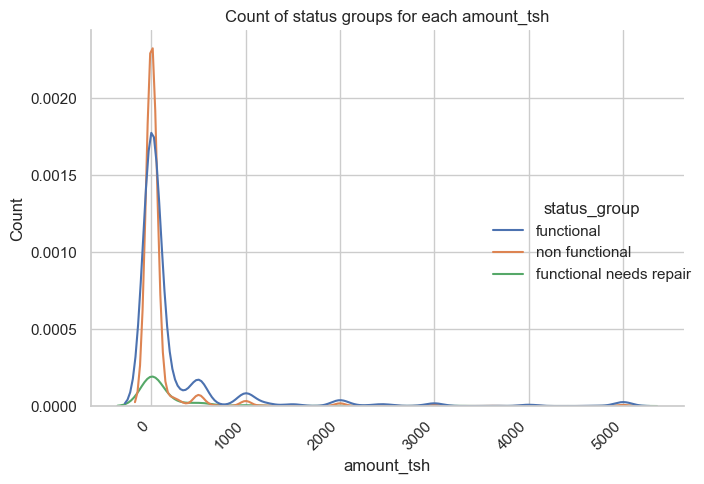

In [28]:
#The feature being examined
x_label = 'amount_tsh'

#show some basic statistics about the feature
print(df[[x_label]].describe())

#display the distribution of data for the feature, divided by status type
plt.figure(figsize=(12, 6))
sns.displot(data=df, x= x_label, hue=original['status_group'], kind='kde')
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

df_reduced_amount = df.drop(df[df.amount_tsh > 5000].index)

plt.figure(figsize=(12, 6))
sns.displot(data=df_reduced_amount, x= x_label, hue=original['status_group'], kind='kde')
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

# Leo Pre-Proccessing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import KBinsDiscretizer


# Calculate the current date
current_date = datetime.now()

values=pd.read_csv('pump_train_values_unclean.csv')
labels=pd.read_csv('pump_train_labels_unclean.csv')
df = values.merge(labels, on='id')

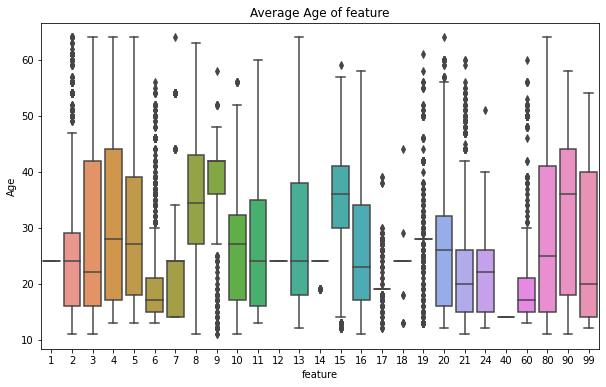

In [2]:
# Calculate age
df['construction_year'] = df['construction_year'].apply(lambda x: x if (0 < x ) else None)
df['age'] = current_date.year - df['construction_year']
# fill NA with median age of other pumps in the same region
df["age"].fillna(df.groupby(['region'])["age"].transform("median"), inplace=True)
df["age"].fillna(df["age"].median(), inplace=True)

# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='region_code', y='age', data=df)
plt.title('Average Age of feature')
plt.xlabel('feature')
plt.ylabel('Age')
plt.show()


In [3]:
# removal of redunant, or badly predicting features
train = df.drop(columns = ['waterpoint_type_group', 'source_class', 'source_type', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_class', 
                   'extraction_type_group', 'construction_year', 'permit', 
                   'recorded_by', 'public_meeting', 'num_private', 'wpt_name', 
                   'date_recorded', 'id', 'funder', 'installer', 'scheme_name', 
                   'scheme_management', 'subvillage', 'ward', 
                   'district_code', 'lga'])

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   amount_tsh       59400 non-null  float64
 1   gps_height       59400 non-null  int64  
 2   longitude        59400 non-null  float64
 3   latitude         59400 non-null  float64
 4   basin            59400 non-null  object 
 5   region           59400 non-null  object 
 6   region_code      59400 non-null  int64  
 7   population       59400 non-null  int64  
 8   extraction_type  59400 non-null  object 
 9   management       59400 non-null  object 
 10  payment          59400 non-null  object 
 11  water_quality    59400 non-null  object 
 12  quantity         59400 non-null  object 
 13  source           59400 non-null  object 
 14  waterpoint_type  59400 non-null  object 
 15  status_group     59400 non-null  object 
 16  age              59400 non-null  float64
dtypes: float64(4

<Figure size 864x432 with 0 Axes>

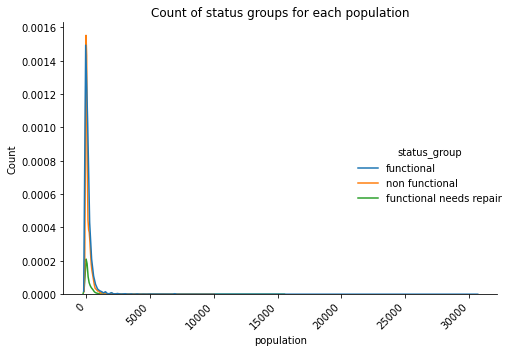

C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


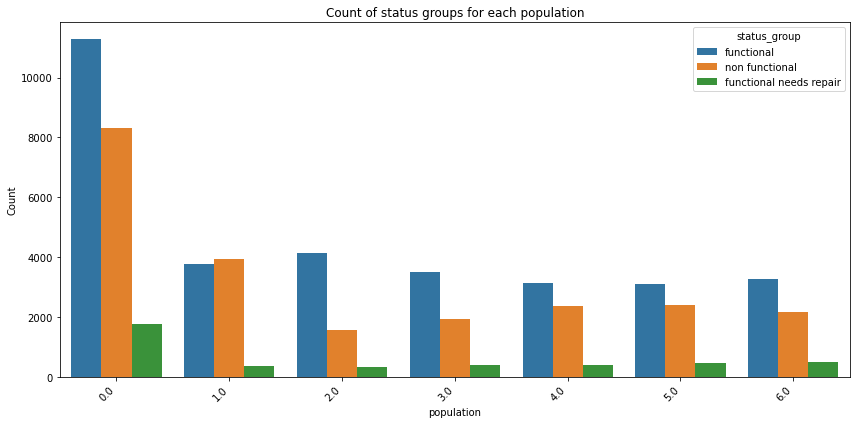

In [4]:
#The feature being examined
x_label = 'population'

#display the distribution of data for the feature, divided by status type
plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.displot(data=train, x= x_label, hue=train['status_group'], kind='kde')
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

population = train.loc[:, ['population']]

binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
binner.fit(population)
population = binner.transform(population)

dataset = pd.DataFrame({'population': population[:, 0]})

x_label = 'population'

plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.countplot(data=dataset, x=x_label, hue=train['status_group'])
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

<Figure size 864x432 with 0 Axes>

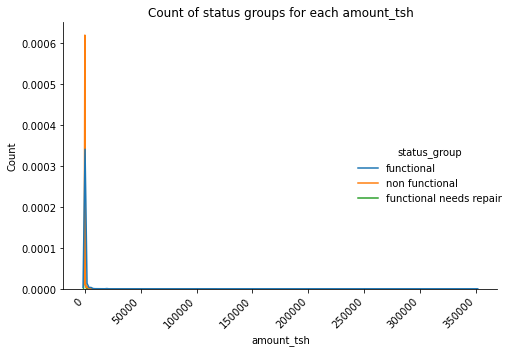

C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


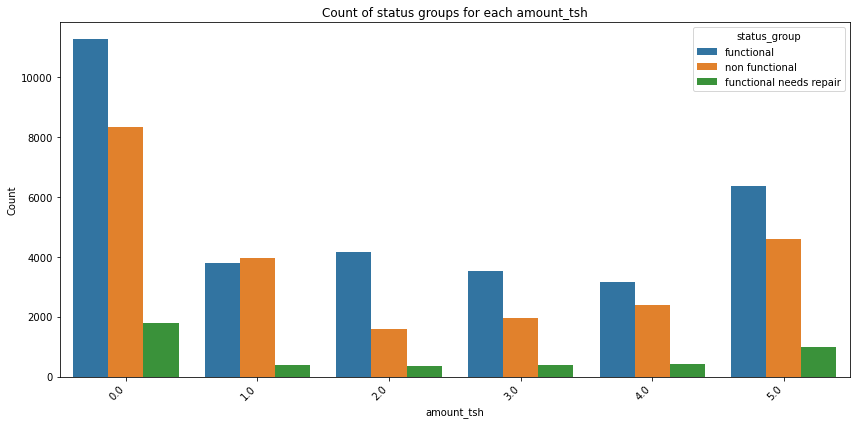

In [5]:
#The feature being examined
x_label = 'amount_tsh'

#display the distribution of data for the feature, divided by status type
plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.displot(data=train, x= x_label, hue=train['status_group'], kind='kde')
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

amount = train.loc[:, ['amount_tsh']]

binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
binner.fit(population)
amount = binner.transform(population)

dataset = pd.DataFrame({'amount_tsh': amount[:, 0]})

plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.countplot(data=dataset, x=x_label, hue=train['status_group'])
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

<Figure size 864x432 with 0 Axes>

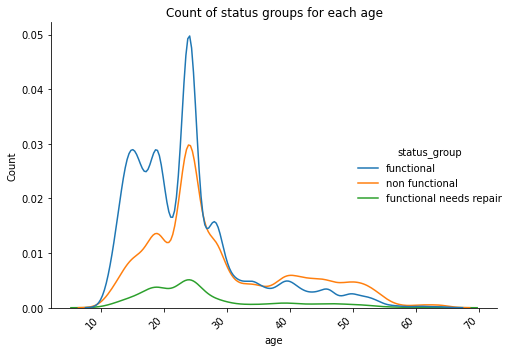

C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


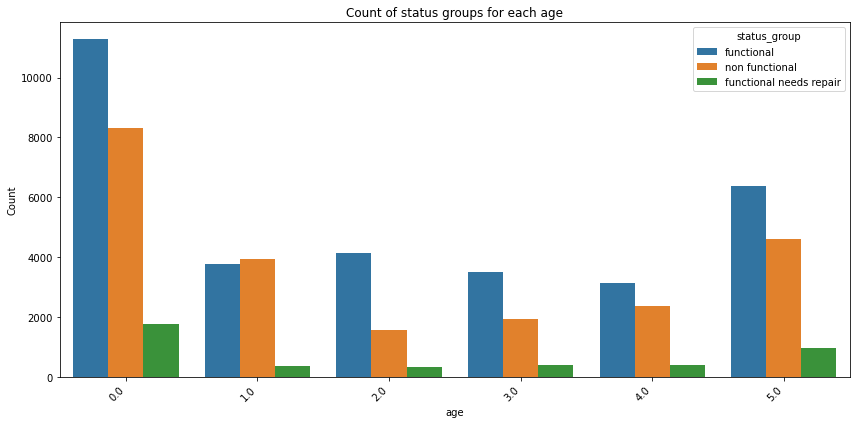

In [6]:
#The feature being examined
x_label = 'age'

#display the distribution of data for the feature, divided by status type
plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.displot(data=train, x= x_label, hue=train['status_group'], kind='kde')
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

amount = train.loc[:, ['age']]

binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
binner.fit(population)
amount = binner.transform(population)

dataset = pd.DataFrame({'age': amount[:, 0]})

plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.countplot(data=dataset, x=x_label, hue=train['status_group'])
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

<Figure size 864x432 with 0 Axes>

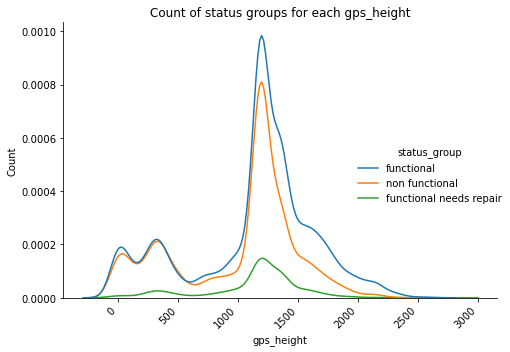

C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


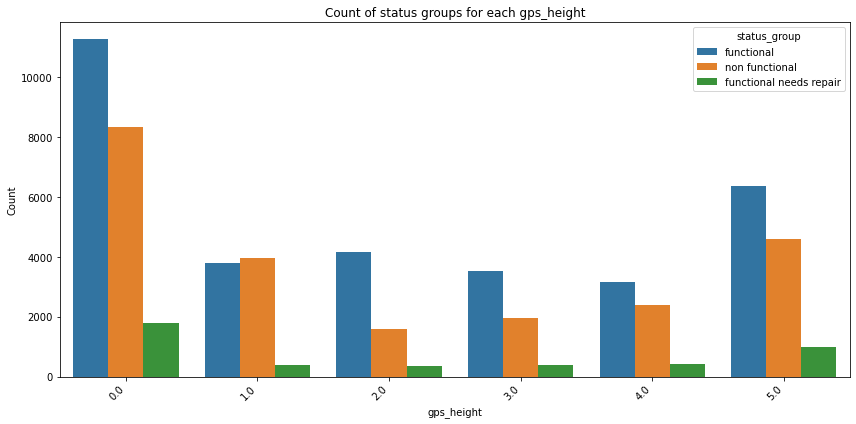

In [7]:
# dataset uses 0.0 to represent NaN values, replace it with np.nan to allow us to impute data easier
train['gps_height'].replace(0.0, np.nan, inplace=True)
# fill NA with mean gps_height of other pumps in the same region
train["gps_height"].fillna(train.groupby(['region'])["gps_height"].transform("median"), inplace=True)
train["gps_height"].fillna(train["gps_height"].median(), inplace=True)

#The feature being examined
x_label = 'gps_height'

#display the distribution of data for the feature, divided by status type
plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.displot(data=train, x= x_label, hue=train['status_group'], kind='kde')
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

amount = train.loc[:, [x_label]]

binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
binner.fit(population)
amount = binner.transform(population)

dataset = pd.DataFrame({x_label: amount[:, 0]})

plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.countplot(data=dataset, x=x_label, hue=train['status_group'])
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

<Figure size 864x432 with 0 Axes>

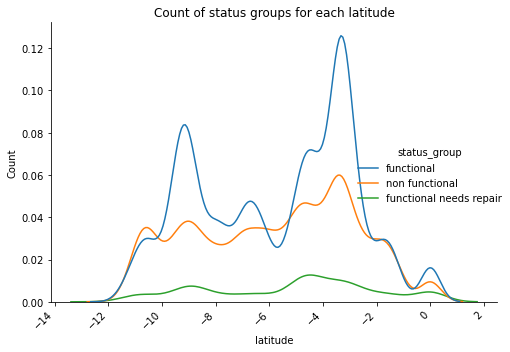

C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


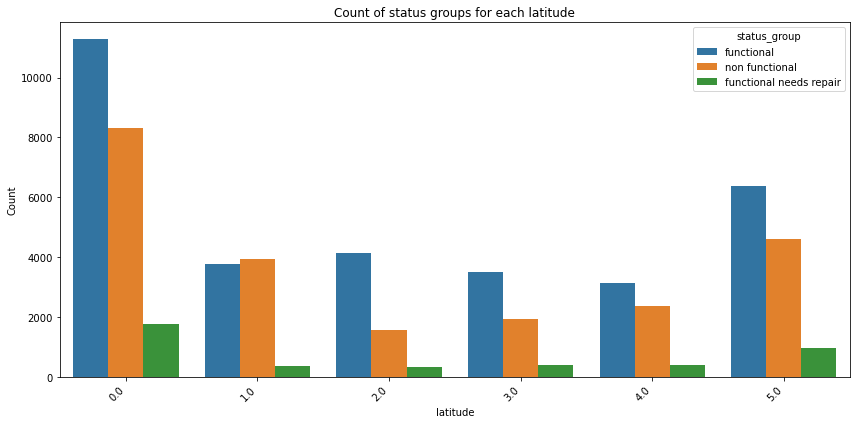

In [8]:
x_label = 'latitude'


# dataset uses 0.0 to represent NaN values, replace it with np.nan to allow us to impute data easier
train[x_label].replace(0.0, np.nan, inplace=True)
# fill NA with mean gps_height of other pumps in the same region
train[x_label].fillna(train.groupby(['region'])[x_label].transform("median"), inplace=True)
train[x_label].fillna(train[x_label].median(), inplace=True)

#display the distribution of data for the feature, divided by status type
plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.displot(data=train, x= x_label, hue=train['status_group'], kind='kde')
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

amount = train.loc[:, [x_label]]

binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
binner.fit(population)
amount = binner.transform(population)

dataset = pd.DataFrame({x_label: amount[:, 0]})

plt.figure(figsize=(12, 6))  # Adjust the size if needed
sns.countplot(data=dataset, x=x_label, hue=train['status_group'])
plt.xticks(rotation=45, ha='right')
plt.xlabel(x_label)
plt.ylabel('Count')
plt.title('Count of status groups for each ' + x_label)
plt.tight_layout()
plt.show()

### creating a pipleine

The pipeline feature in scikit-learn will be used for all of the value imputation, this will allow us to easily do k-fold corss validation within parameter searches without introducing data leakage. To do so we will create our own transfromer functions.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from datetime import datetime

# Calculate the current date
current_date = datetime.now()
# Create Label Encoder
label_encoder = LabelEncoder()


In [22]:
def getFinalFeatures(dataframe):
    df['construction_year'] = df['construction_year'].apply(lambda x: x if (0 < x ) else None)
    df['age'] = current_date.year - df['construction_year']
    
    train = df.drop(columns = ['waterpoint_type_group', 'source_class', 'source_type', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_class', 
                   'extraction_type_group', 'construction_year', 'permit', 
                   'recorded_by', 'public_meeting', 'num_private', 'wpt_name', 
                   'date_recorded', 'id', 'funder', 'installer', 'scheme_name', 
                   'scheme_management', 'subvillage', 'ward', 
                   'district_code', 'lga', 'region'])
    return train
    
class CustomImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Compute medians for age by region_code
        X['age'].replace(0.0, np.nan, inplace=True)
        self.age_by_region = X.groupby(X['region_code'])['age'].median()
        # Compute medians for gps_height by region_code
        X['gps_height'].replace(0.0, np.nan, inplace=True)
        self.height_by_region = X.groupby(X['region_code'])['gps_height'].median()
        # Compute medians for gps_height by region_code
        X['latitude'].replace(0.0, np.nan, inplace=True)
        self.latitude_by_region = X.groupby(X['region_code'])['latitude'].median()
        return self

    def transform(self, X):
        # Replace 0 in 'age' with median grouped by basin
        X['age'].replace(0.0, np.nan, inplace=True)
        X['age'].fillna(X['region_code'].map(self.age_by_region), inplace=True)
        X['age'].fillna(X['age'].median(), inplace=True)
        
        # Replace 0 in 'gps_height' with median grouped by basin
        X['gps_height'].replace(0.0, np.nan, inplace=True)
        X['gps_height'].fillna(X['region_code'].map(self.height_by_region), inplace=True)
        X['gps_height'].fillna(X['gps_height'].median(), inplace=True)
        
        # Replace 0 in 'lattitude' with median grouped by basin
        X['latitude'].replace(0.0, np.nan, inplace=True)
        X['latitude'].fillna(X['region_code'].map(self.latitude_by_region), inplace=True)
        X['latitude'].fillna(X['latitude'].median(), inplace=True)

        return X
    

class CustomDiscretizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        
        self.population_binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        population = X.loc[:, ['population']]
        self.population_binner.fit(population)
        
        self.age_binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        age = X.loc[:, ['age']]
        self.age_binner.fit(age)
        
        self.amount_binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        amount = X.loc[:, ['amount_tsh']]
        self.amount_binner.fit(amount)
        
        self.height_binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        height = X.loc[:, ['gps_height']]
        self.height_binner.fit(height)
        
        self.latitude_binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        latitude = X.loc[:, ['latitude']]
        self.latitude_binner.fit(latitude)
        
        return self

    def transform(self, X):
        population = X.loc[:, ['population']]
        X['population'] = self.population_binner.transform(population)
        
        age = X.loc[:, ['age']]
        X['age'] = self.age_binner.transform(age)
        
        amount = X.loc[:, ['amount_tsh']]
        X['amount'] = self.amount_binner.transform(amount)
        
        height = X.loc[:, ['gps_height']]
        X['height'] = self.height_binner.transform(height)
        
        latitude = X.loc[:, ['latitude']]
        X['latitude'] = self.latitude_binner.transform(latitude)
        
        return X
    
values=pd.read_csv('pump_train_values_unclean.csv')
labels=pd.read_csv('pump_train_labels_unclean.csv')
df = values.merge(labels, on='id')
df = getFinalFeatures(df)
final = df.drop(columns=['status_group'])

# Define the different column types
categorical_columns = ['region_code'] + list(final.select_dtypes(include=['object']).columns)
numerical_columns = ['amount_tsh', 'gps_height', 'population', 'age', 'latitude']

# pipeline for tranforming categorical and numerical features seperately
column_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', StandardScaler()),  # Standardize numerical columns
                ('pca', PCA(n_components=2))  # Apply PCA to numerical columns
            ]), numerical_columns),
            ('cat',Pipeline([
                ('encode', OneHotEncoder()),  # Apply OneHotEncoder to categorical columns
            ]), categorical_columns),  
        ],
        remainder='passthrough'  # Pass through any columns not specified
    )),
])

# pipeline to impute and process data
preprocessing_pipeline = Pipeline([
    ('imputer', CustomImputer()),  #imputation for features
    ('column_pipeline', column_pipeline)
])

# pipeline to impute, discretize, and process data
preprocessing_pipeline_discretizer = Pipeline([
    ('imputer', CustomImputer()),  #imputation for features
    ('discretizer', CustomDiscretizer()), # discretize continous values
    ('column_pipeline', column_pipeline)
])

# Leo - Classification

In [15]:
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.12.2-py3-none-any.whl (257 kB)


In [16]:
from imblearn.over_sampling import RandomOverSampler

In [17]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

# Function to display classifier metrics
def evaluatePred(y_test, y_pred):
    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix',fontsize=16)
    plt.show()

    print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
    print('Recall: ',metrics.recall_score(y_test, y_pred, zero_division=1, average=None))
    print('Precision: ',metrics.precision_score(y_test, y_pred, zero_division=1, average=None))
    
    report = metrics.classification_report(y_test, y_pred, zero_division=1, output_dict=True)
    
    # Convert report to DataFrame
    report_df = pd.DataFrame(report)
    display(report_df)

In [18]:
values=pd.read_csv('pump_train_values_unclean.csv')
labels=pd.read_csv('pump_train_labels_unclean.csv')
df = values.merge(labels, on='id')

df = getFinalFeatures(df)

df['status_group'] = label_encoder.fit_transform(df['status_group'])

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['status_group']), df['status_group'], test_size=0.2, random_state=42)

# Define stratified k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Finding best parameter settings


In [134]:
'''

# Classifier being used
clf_RF = RandomForestClassifier()

# parameters being tested on classifier
param_dist_RF = {'classifier__bootstrap': [True, False],
             'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'classifier__max_features': ['log2','sqrt'],
             'classifier__min_samples_leaf': [1, 2, 4],
             'classifier__min_samples_split': [2, 5, 10],
             'classifier__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


# Define prediction pipeline
prediction_pipeline = Pipeline([
      # Apply CustomImputer to all columns
    ('preprocessing', preprocessing_pipeline),  # Preprocessing stage
    ('classifier', clf_RF)  # Prediction stage
])

search_RF_Continuous = RandomizedSearchCV(prediction_pipeline, param_distributions=param_dist_RF, n_iter=50, cv = kfold, random_state=42)
search_RF_Continuous.fit(X_train, y_train)

'''

"\n\n# Classifier being used\nclf_RF = RandomForestClassifier()\n\n# parameters being tested on classifier\nparam_dist_RF = {'classifier__bootstrap': [True, False],\n             'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],\n             'classifier__max_features': ['log2','sqrt'],\n             'classifier__min_samples_leaf': [1, 2, 4],\n             'classifier__min_samples_split': [2, 5, 10],\n             'classifier__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}\n\n\n# Define prediction pipeline\nprediction_pipeline = Pipeline([\n      # Apply CustomImputer to all columns\n    ('preprocessing', preprocessing_pipeline),  # Preprocessing stage\n    ('classifier', clf_RF)  # Prediction stage\n])\n\nsearch_RF_Continuous = RandomizedSearchCV(prediction_pipeline, param_distributions=param_dist_RF, n_iter=50, cv = kfold, random_state=42)\nsearch_RF_Continuous.fit(X_train, y_train)\n\n"

In [ ]:
'''
clf_NN = MLPClassifier()

param_dist_NN = {
    'classifier__hidden_layer_sizes': [(10,), (100,), (5, 10, 5), (10,100,10)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__solver': ['adam', 'lbfgs', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.005],
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'classifier__early_stopping': [True, False]
}

# Define prediction pipeline
prediction_pipeline = Pipeline([
      # Apply CustomImputer to all columns
    ('preprocessing', preprocessing_pipeline),  # Preprocessing stage
    ('classifier', clf_NN)  # Prediction stage
])

search_NN_Continuous = RandomizedSearchCV(prediction_pipeline, param_distributions=param_dist_NN, n_iter=50, cv = kfold, random_state=42)
search_NN_Continuous.fit(X_train, y_train)
'''

## Testing with best parameter settings

Two classifiers are being used, Random Forest, and MLP Classifier. Each is run on the differnt cmbinations of these four pipleine variables (continous / discrete / normal sampling / over sampling)

In [23]:
# Classifier being used with best parameter settings found
clf_RF = RandomForestClassifier(n_estimators=600, 
                                min_samples_split=2, 
                                min_samples_leaf=2, 
                                max_features='sqrt', 
                                max_depth=70,
                                bootstrap=False)


# Define prediction pipeline
RF_predictor_continuous = Pipeline([
      # Apply CustomImputer to all columns
    ('preprocessing', preprocessing_pipeline),  # Preprocessing stage
    ('classifier', clf_RF)  # Prediction stage
])

# Define prediction pipeline
RF_predictor_discrete = Pipeline([
      # Apply CustomImputer to all columns
    ('preprocessing', preprocessing_pipeline_discretizer),  # Preprocessing stage
    ('classifier', clf_RF)  # Prediction stage
])


RF_predictor_continuous.fit(X_train, y_train)
RF_predictor_discrete.fit(X_train, y_train)

       amount_tsh  gps_height  longitude  latitude        basin  region_code  \
3607         50.0      2092.0  35.426020 -4.227446     Internal           21   
50870         0.0      1189.0  35.510074 -5.724555     Internal            1   
20413         0.0      1189.0  32.499866 -9.081222   Lake Rukwa           12   
52806         0.0      1189.0  34.060484 -8.830208       Rufiji           12   
50091       300.0      1023.0  37.032690 -6.040787  Wami / Ruvu            5   

       population extraction_type   management                payment  \
3607          160         gravity  water board         pay per bucket   
50870           0   india mark ii          vwc              never pay   
20413           0           other          vwc              never pay   
52806           0         gravity          vwc            pay monthly   
50091         120           other          vwc  pay when scheme fails   

      water_quality      quantity        source     waterpoint_type   age  
3607

C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', CustomImputer()),
                                 ('discretizer', CustomDiscretizer()),
                                 ('column_pipeline',
                                  Pipeline(steps=[('preprocessor',
                                                   ColumnTransformer(remainder='passthrough',
                                                                     transformers=[('num',
                                                                                    Pipeline(steps=[('scaler',
                                                                                                     StandardScaler()),
                                                                                                    ('pca',
                                                                                                     PCA(n_components=2))]),
                                                                                    ['amount_tsh',
                                                                                     'gps_height',
                                                                                     'population',
                                                                                     'age',
                                                                                     'latitude']),
                                                                                   ('cat',
                                                                                    Pipeline(steps=[('encode',
                                                                                                     OneHotEncoder())]),
                                                                                    ['region_code',
                                                                                     'basin',
                                                                                     'extraction_type',
                                                                                     'management',
                                                                                     'payment',
                                                                                     'water_quality',
                                                                                     'quantity',
                                                                                     'source',
                                                                                     'waterpoint_type'])]))]))])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=70,
                                        min_samples_leaf=2,
                                        n_estimators=600))])

In [145]:
# Define prediction pipeline
RF_predictor_continuous_res = Pipeline([
      # Apply CustomImputer to all columns
    ('preprocessing', preprocessing_pipeline),  # Preprocessing stage
    ('classifier', clf_RF)  # Prediction stage
])

# Define prediction pipeline
RF_predictor_discrete_res = Pipeline([
      # Apply CustomImputer to all columns
    ('preprocessing', preprocessing_pipeline_discretizer),  # Preprocessing stage
    ('classifier', clf_RF)  # Prediction stage
])

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

RF_predictor_continuous_res.fit(X_train_res, y_train_res)
RF_predictor_discrete_res.fit(X_train_res, y_train_res)


C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\leome\anaconda3\lib\site-packages\sklearn\preprocessing\_discre

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', CustomImputer()),
                                 ('discretizer', CustomDiscretizer()),
                                 ('column_pipeline',
                                  Pipeline(steps=[('preprocessor',
                                                   ColumnTransformer(remainder='passthrough',
                                                                     transformers=[('num',
                                                                                    Pipeline(steps=[('scaler',
                                                                                                     StandardScaler()),
                                                                                                    ('pca',
                                                                                                     PCA(n_components=2))]),
                                                                                    ['amount_tsh',
                                                                                     'gps_height',
                                                                                     'population',
                                                                                     'age',
                                                                                     'latitude']),
                                                                                   ('cat',
                                                                                    Pipeline(steps=[('encode',
                                                                                                     OneHotEncoder())]),
                                                                                    ['basin',
                                                                                     'extraction_type',
                                                                                     'management',
                                                                                     'payment',
                                                                                     'water_quality',
                                                                                     'quantity',
                                                                                     'source',
                                                                                     'waterpoint_type'])]))]))])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=70,
                                        min_samples_leaf=2,
                                        n_estimators=600))])

In [156]:
y_pred = RF_predictor_continuous.predict(X_test)
evaluatePred(y_test, y_pred)

y_pred = RF_predictor_discrete.predict(X_test)
evaluatePred(y_test, y_pred)

y_pred = RF_predictor_continuous_res.predict(X_test)
evaluatePred(y_test, y_pred)

y_pred = RF_predictor_discrete_res.predict(X_test)
evaluatePred(y_test, y_pred)

ValueError: columns are missing: {'height', 'amount'}

In [152]:
# Classifier being used
clf_NN = MLPClassifier()

# Define prediction pipeline
RF_predictor_continuous = Pipeline([
      # Apply CustomImputer to all columns
    ('preprocessing', preprocessing_pipeline),  # Preprocessing stage
    ('classifier', clf_NN)  # Prediction stage
])

# Define prediction pipeline
RF_predictor_discrete = Pipeline([
      # Apply CustomImputer to all columns
    ('preprocessing', preprocessing_pipeline_discretizer),  # Preprocessing stage
    ('classifier', clf_NN)  # Prediction stage
])


NN_predictor_continuous.fit(X_train, y_train)
NN_predictor_discrete.fit(X_train, y_train)


NameError: name 'MLPClassifier' is not defined

In [ ]:
# Define prediction pipeline
RF_predictor_continuous_res = Pipeline([
      # Apply CustomImputer to all columns
    ('preprocessing', preprocessing_pipeline),  # Preprocessing stage
    ('classifier', clf_NN)  # Prediction stage
])

# Define prediction pipeline
RF_predictor_discrete_res = Pipeline([
      # Apply CustomImputer to all columns
    ('preprocessing', preprocessing_pipeline_discretizer),  # Preprocessing stage
    ('classifier', clf_NN)  # Prediction stage
])

NN_predictor_continuous_res.fit(X_train_res, y_train_res)
NN_predictor_discrete_res.fit(X_train_res, y_train_res)

In [ ]:
y_pred = NN_predictor_continuous.predict(X_test)
evaluatePred(y_test, y_pred)

y_pred = NN_predictor_discrete.predict(X_test)
evaluatePred(y_test, y_pred)

y_pred = NN_predictor_continuous_res.predict(X_test)
evaluatePred(y_test, y_pred)

y_pred = NN_predictor_discrete_res.predict(X_test)
evaluatePred(y_test, y_pred)